In [1]:
# Imports for NumPy, pandas, matplotlib, and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Notebook magic to inline plots
%matplotlib inline
# Store matplotlib plots as both png and pdf --> for 
# better quality graphics when exporting the notebook
# to pdf.
from IPython.display import set_matplotlib_formats
from IPython.display import Image, Video
set_matplotlib_formats('png', 'pdf')
# Load seaborn defaults
sns.set(rc={'figure.dpi':300})
sns.set_style("ticks")
sns.set_context("talk")

In [3]:
from scipy.stats import norm, rv_histogram

In [4]:
from scipy.optimize import minimize

In [5]:
from galibrate.sampled_parameter import SampledParameter
from galibrate import GAO

/home/blake/src/python/GAlibrate/galibrate/gao.py:11: RuntimeWarning: ------Running GAO with numba optimization.------
  warnings.warn("------Running GAO with numba optimization.------", RuntimeWarning)


In [6]:
def fragment_frequency(fragments):
    frag_counts, _edges = np.histogram(fragments, bins=edges)
    frag_freq = 100 * frag_counts / len(fragments)
    return frag_freq
    

In [7]:
def surface_ablation(initial, Pfrag, fsl, Ndsl):
    """The surface layer of particles is ablated and forms fragments.
    """
    rads = initial / 2
    Nfrag = int(Pfrag*len(rads))
    shell_width = fsl * rads[:Nfrag]
    rcore = rads[:Nfrag] - shell_width
    Dcore = 2 * rcore
    rsl = ( rads[:Nfrag]**3 - rcore**3)**(1/3)
    rfrag = rsl/(Ndsl)**(1/3)
    Dfrag = 2 * rfrag
    frag_list = list()
    for i in range(Ndsl):
        frag_list.append(Dfrag)
    frag_list.append(initial[Nfrag:])   
    frag_list.append(Dcore)
    fragments = np.concatenate(frag_list)
    return fragments

In [8]:
def cost_surface_ablation(params):
    Pfrag, fsl, Ndsl = params
    Ndsl = int(Ndsl)
    fragments = surface_ablation(sample_sizes, Pfrag, fsl, Ndsl)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['laser_low'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [9]:
def fitness_surface_ablation(theta):
    return -cost_surface_ablation(10**theta)

In [10]:
sampled_parameters_sa = [SampledParameter(name="Pfrag", loc=np.log10(1e-2), width=2),
                         SampledParameter(name="fsl", loc=np.log10(6e-2), width=np.log10(10e-2)-np.log10(6e-2)),
                         SampledParameter(name="Ndsl", loc=np.log10(1), width=3)]

In [11]:
def particle_split(initial, Pfrag, Nd):
    """Particles get split into equal volume fragments.
    """    
    rads = initial / 2
    Vo = (4/3)*np.pi*rads**3
    Nfrag = int(Pfrag*len(rads))
    Vfrag = Vo[:Nfrag] / Nd
    rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
    Dfrag = rfrag*2
    frag_list = list()
    for i in range(Nd):
        frag_list.append(Dfrag)
    frag_list.append(initial[Nfrag:])    
    fragments = np.concatenate(frag_list)
    return fragments

In [12]:
def cost_particle_split(params):
    Pfrag, Nd = params
    Nd = int(Nd)
    fragments = particle_split(sample_sizes, Pfrag, Nd)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['laser_low'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [13]:
def fitness_particle_split(theta):
    return -cost_particle_split(10**theta)

In [14]:
sampled_parameters_ps = [SampledParameter(name="Pfrag", loc=np.log10(1e-2), width=2),
                         SampledParameter(name="Nd", loc=np.log10(2), width=3)]

In [15]:
def surface_ablation_unequal(initial, Pfrag, fsl, Ndsl):
    """The surface layer of particles is ablated and forms fragments of unequal size.
    """
    rads = initial / 2
    Nfrag = int(Pfrag*len(rads))
    shell_width = fsl * rads[:Nfrag]
    rcore = rads[:Nfrag] - shell_width
    Dcore = 2 * rcore
    frag_list = list()
    Vsl = (4/3)*np.pi * ( rads[:Nfrag]**3 - rcore**3)
    np.random.seed(1990)
    for vsl in Vsl:
        V_rand = np.random.random(Ndsl-1) * vsl
        V_rand = np.concatenate(([0], V_rand, [vsl]))
        V_rand.sort()
        V_frags = V_rand[1:] - V_rand[:-1]
        r_frags = ((3/(4*np.pi)) * V_frags)**(1/3)
        D_frags = 2 * r_frags
        frag_list.append(D_frags)
    frag_list.append(initial[Nfrag:])
    frag_list.append(Dcore)
    fragments = np.concatenate(frag_list)
    return fragments

In [16]:
def cost_surface_ablation_unequal(params):
    Pfrag, fsl, Ndsl = params
    Ndsl = int(Ndsl)
    fragments = surface_ablation_unequal(sample_sizes, Pfrag, fsl, Ndsl)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['laser_low'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [17]:
def fitness_surface_ablation_unequal(theta):
    return -cost_surface_ablation_unequal(10**theta)

In [18]:
def particle_split_unequal(initial, Pfrag, Nd):
    """The surface layer of particles is ablated and forms fragments of unequal size.
    """
    rads = initial / 2
    Vo = (4/3)*np.pi*rads**3
    Nfrag = int(Pfrag*len(rads))
    Vfrag = Vo[:Nfrag]
    frag_list = list()
    np.random.seed(1991)
    for vsl in Vfrag:
        V_rand = np.random.random(Nd-1) * vsl
        V_rand = np.concatenate(([0], V_rand, [vsl]))
        V_rand.sort()
        V_frags = V_rand[1:] - V_rand[:-1]
        r_frags = ((3/(4*np.pi)) * V_frags)**(1/3)
        D_frags = 2 * r_frags
        frag_list.append(D_frags)
    frag_list.append(initial[Nfrag:])
    fragments = np.concatenate(frag_list)
    return fragments

In [19]:
def cost_particle_split_unequal(params):
    Pfrag, Nd = params
    Nd = int(Nd)
    fragments = particle_split_unequal(sample_sizes, Pfrag, Nd)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['laser_low'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [20]:
def fitness_particle_split_unequal(theta):
    return -cost_particle_split_unequal(10**theta)

# 5 nm

In [21]:
# Load the data
dist = pd.read_csv('5nm_distribution_moreparticles.csv')
dist.head()

,size,initial,laser_low,laser_high
0,0.2,0.000000,0.000000,0.000000
1,0.4,2.393617,0.000000,0.000000
2,0.6,0.265957,0.000000,9.562842
3,0.8,0.000000,4.582651,15.300546
4,1.0,0.265957,5.073650,5.464481


In [22]:
# Get the histogram bin centers
centers = dist['size'].to_numpy()
centers

array([ 0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,
        2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,
        4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,
        6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,
        9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. ,
       11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2,
       13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2, 15.4,
       15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4, 17.6,
       17.8, 18. , 18.2, 18.4])

In [23]:
# Histogram bin width
bw = centers[1] - centers[0]
bw

0.2

In [24]:
# Create the corresponding edges for the histogram
edges = np.linspace(centers[0] - 0.5*bw, centers[-1] + 0.5*bw, len(centers)+1, endpoint=True)
edges

array([ 0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  4.3,
        4.5,  4.7,  4.9,  5.1,  5.3,  5.5,  5.7,  5.9,  6.1,  6.3,  6.5,
        6.7,  6.9,  7.1,  7.3,  7.5,  7.7,  7.9,  8.1,  8.3,  8.5,  8.7,
        8.9,  9.1,  9.3,  9.5,  9.7,  9.9, 10.1, 10.3, 10.5, 10.7, 10.9,
       11.1, 11.3, 11.5, 11.7, 11.9, 12.1, 12.3, 12.5, 12.7, 12.9, 13.1,
       13.3, 13.5, 13.7, 13.9, 14.1, 14.3, 14.5, 14.7, 14.9, 15.1, 15.3,
       15.5, 15.7, 15.9, 16.1, 16.3, 16.5, 16.7, 16.9, 17.1, 17.3, 17.5,
       17.7, 17.9, 18.1, 18.3, 18.5])

In [25]:
# Create a distribution object from the histogrammed frequencies.
rv_initial = rv_histogram((dist['initial'].to_numpy(), edges))
rv_initial

In [26]:
sample_sizes = rv_initial.rvs(size=10000, random_state=14983)
sample_sizes[:10]

array([5.68614024, 5.63066325, 5.1626203 , 5.84081428, 5.48341581,
       6.17039525, 5.16387749, 5.42416762, 5.46450706, 5.87596215])

[0.   2.39 0.36 0.   0.21]


(0, 40)

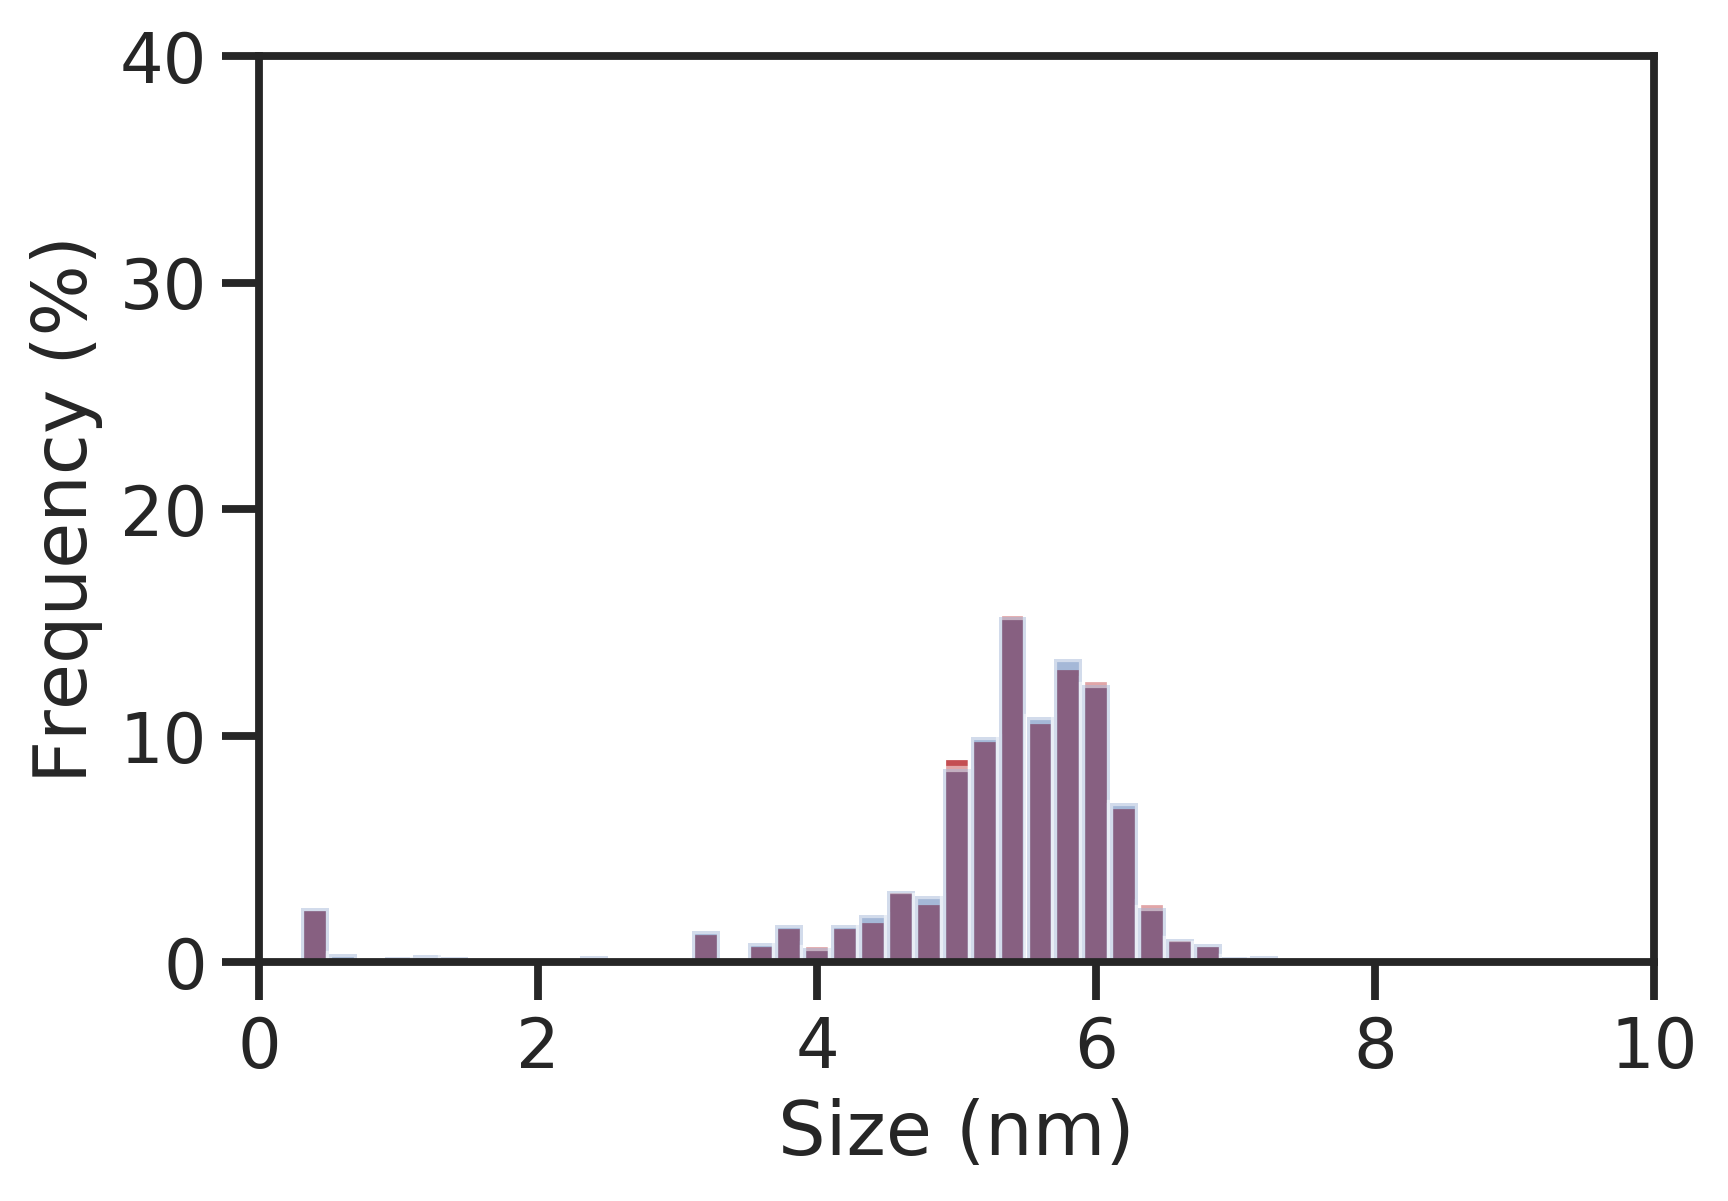

In [27]:
counts, _edges = np.histogram(sample_sizes, bins=edges)

freq = 100 * counts / len(sample_sizes)
print(freq[:5])
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.hist(centers, bins=edges, weights=freq, color='b', alpha=0.5)
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

(0, 40)

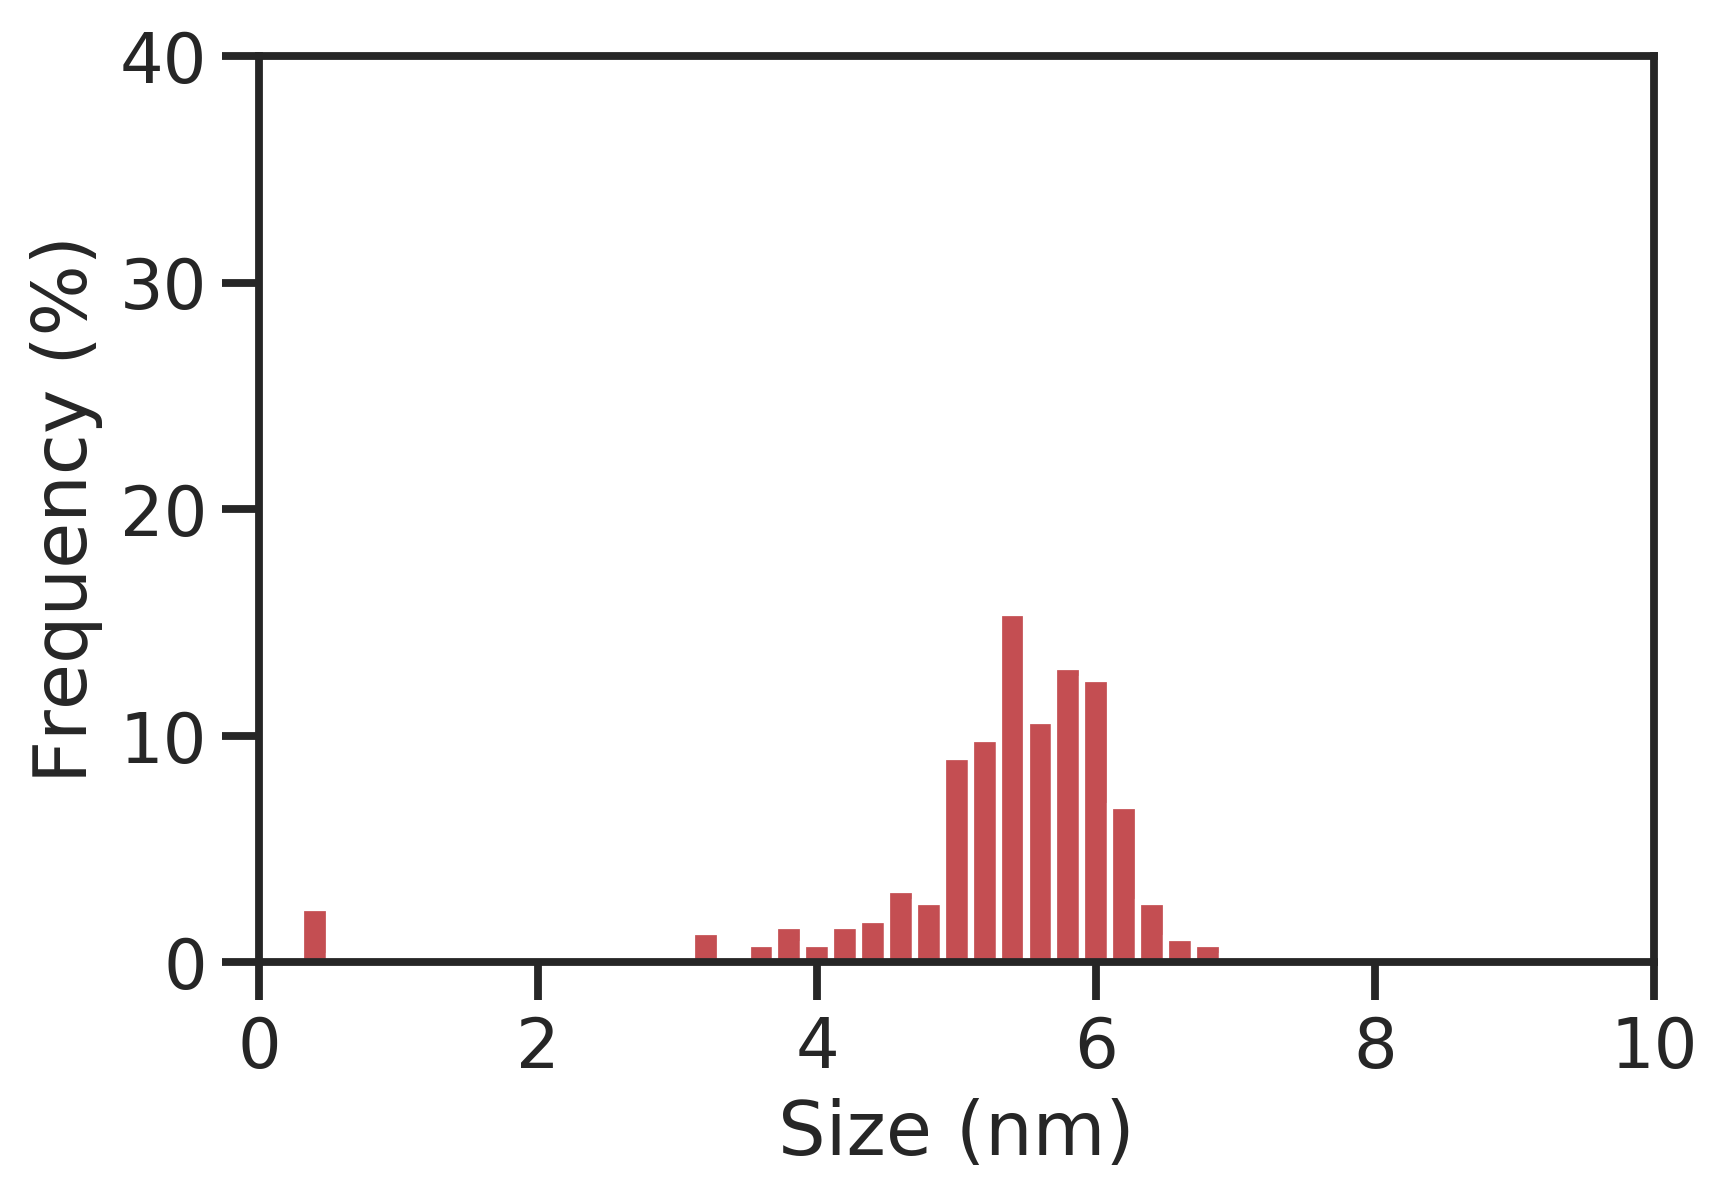

In [28]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

## Surface Layer Ablation - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [29]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [30]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [31]:
#nrepeats = 3
# Set the active point population size
population_size = 1000
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

Generations: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


[ 0.03691823  0.06079977 10.89682695] 294.40319032078617


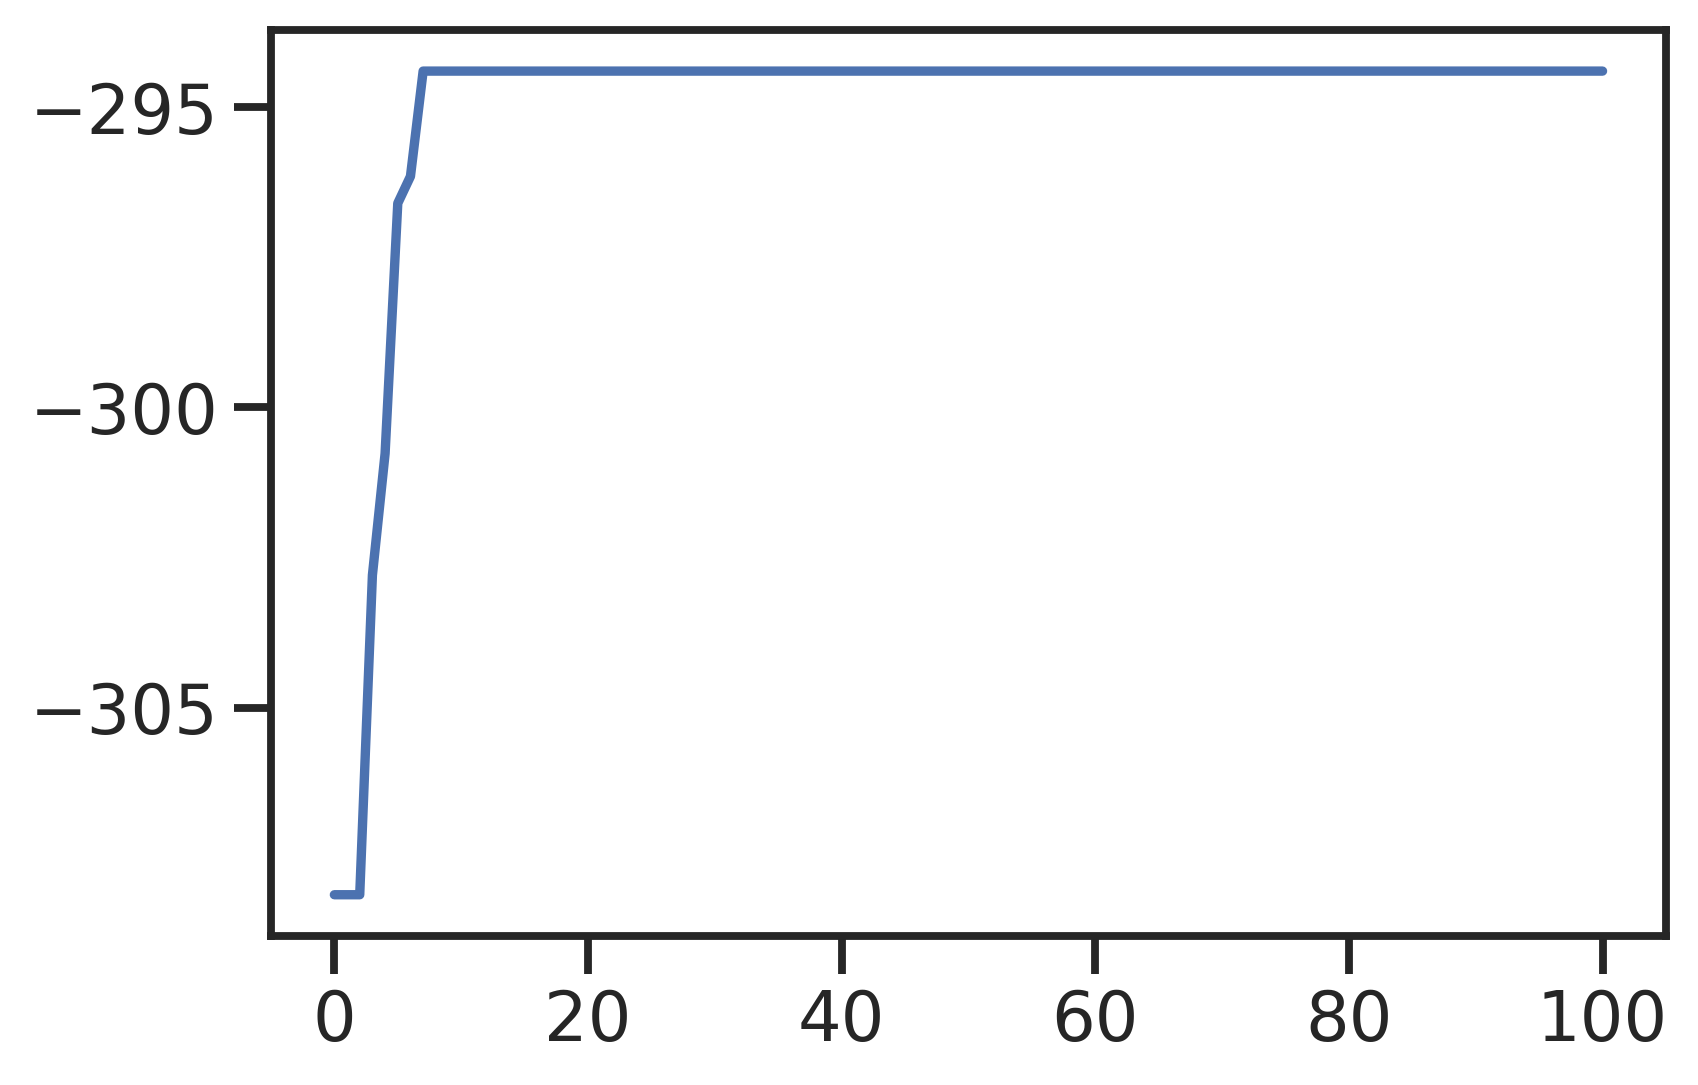

In [32]:
plt.plot(gao.best_fitness_per_generation)

In [33]:
AIC_sa = 2*len(fit_parms) + fit_cost
AIC_sa

300.40319032078617

In [34]:
fragments = surface_ablation(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

(0, 25)

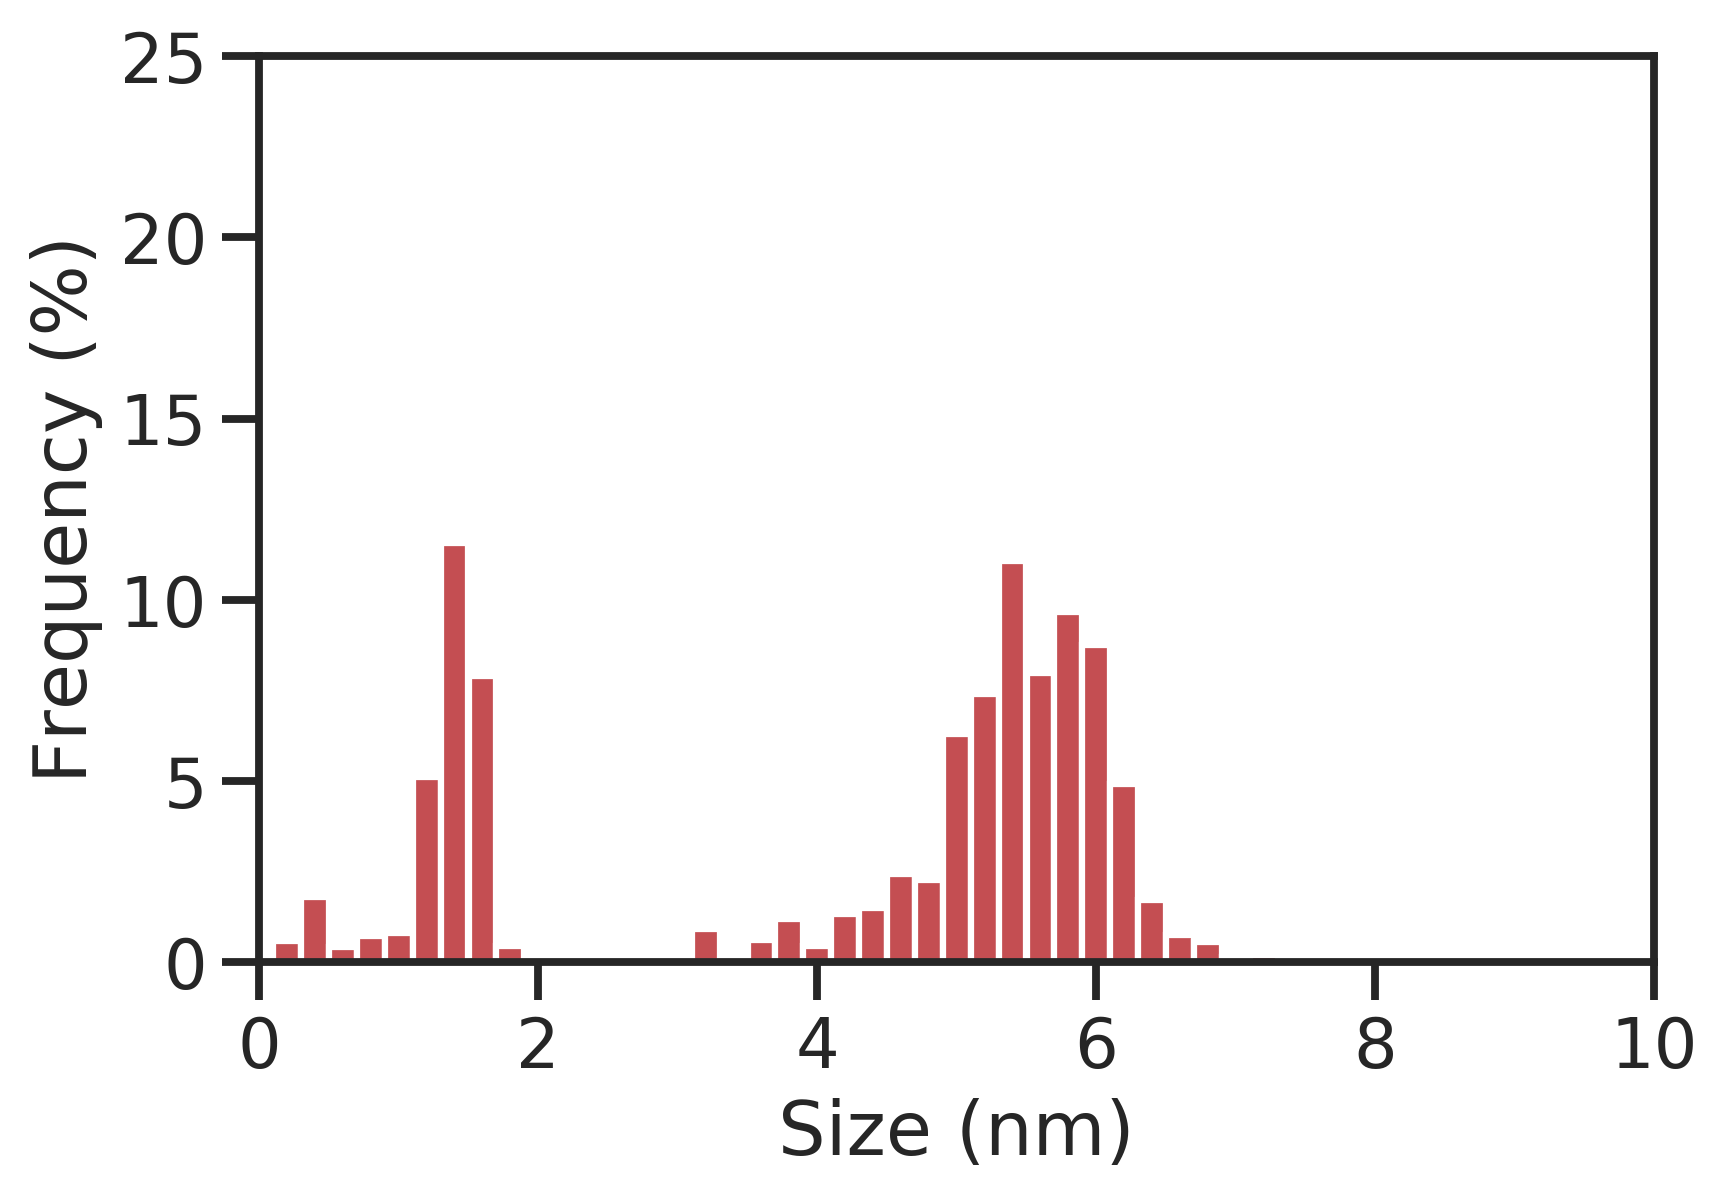

In [35]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

In [36]:
np.savetxt('5nm_nlsfit_moreTEM_centers.txt', centers)
np.savetxt('5nm_nlsfit_moreTEM_edges.txt', edges)
np.savetxt('5nm_nlsfit_moreTEM_frequency_sa.txt', frag_freq)

Text(1, 22, 'SSE=294')

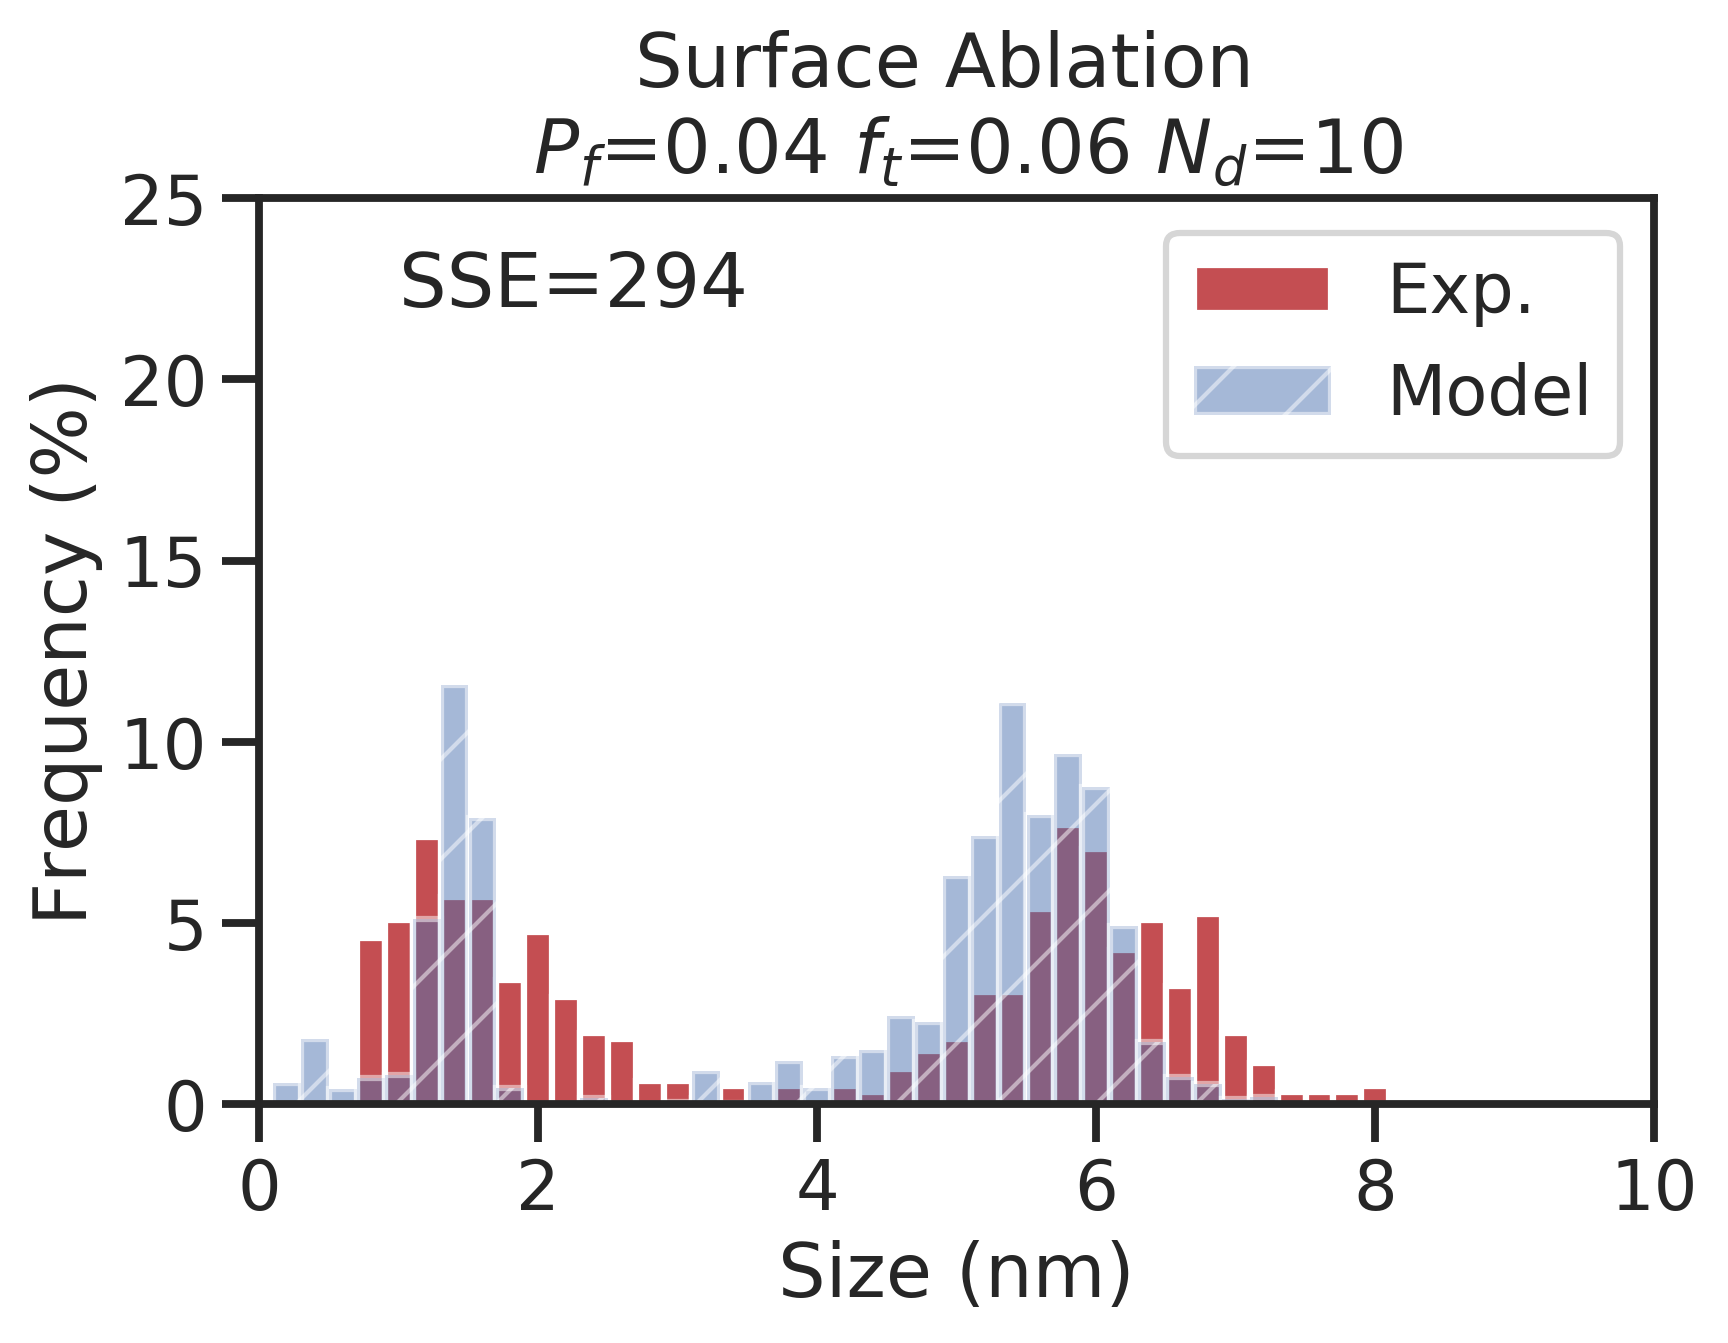

In [37]:
plt.hist(centers, bins=edges, weights=dist['laser_low'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(1,22, "SSE={:.0f}".format(fit_cost))

## Particle Split - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [38]:
# Set the active point population size
population_size = 1000
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_ps, fitness_particle_split, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)

Generations: 100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


[1.52918496e-02 2.56296896e+01] 351.7248815517577


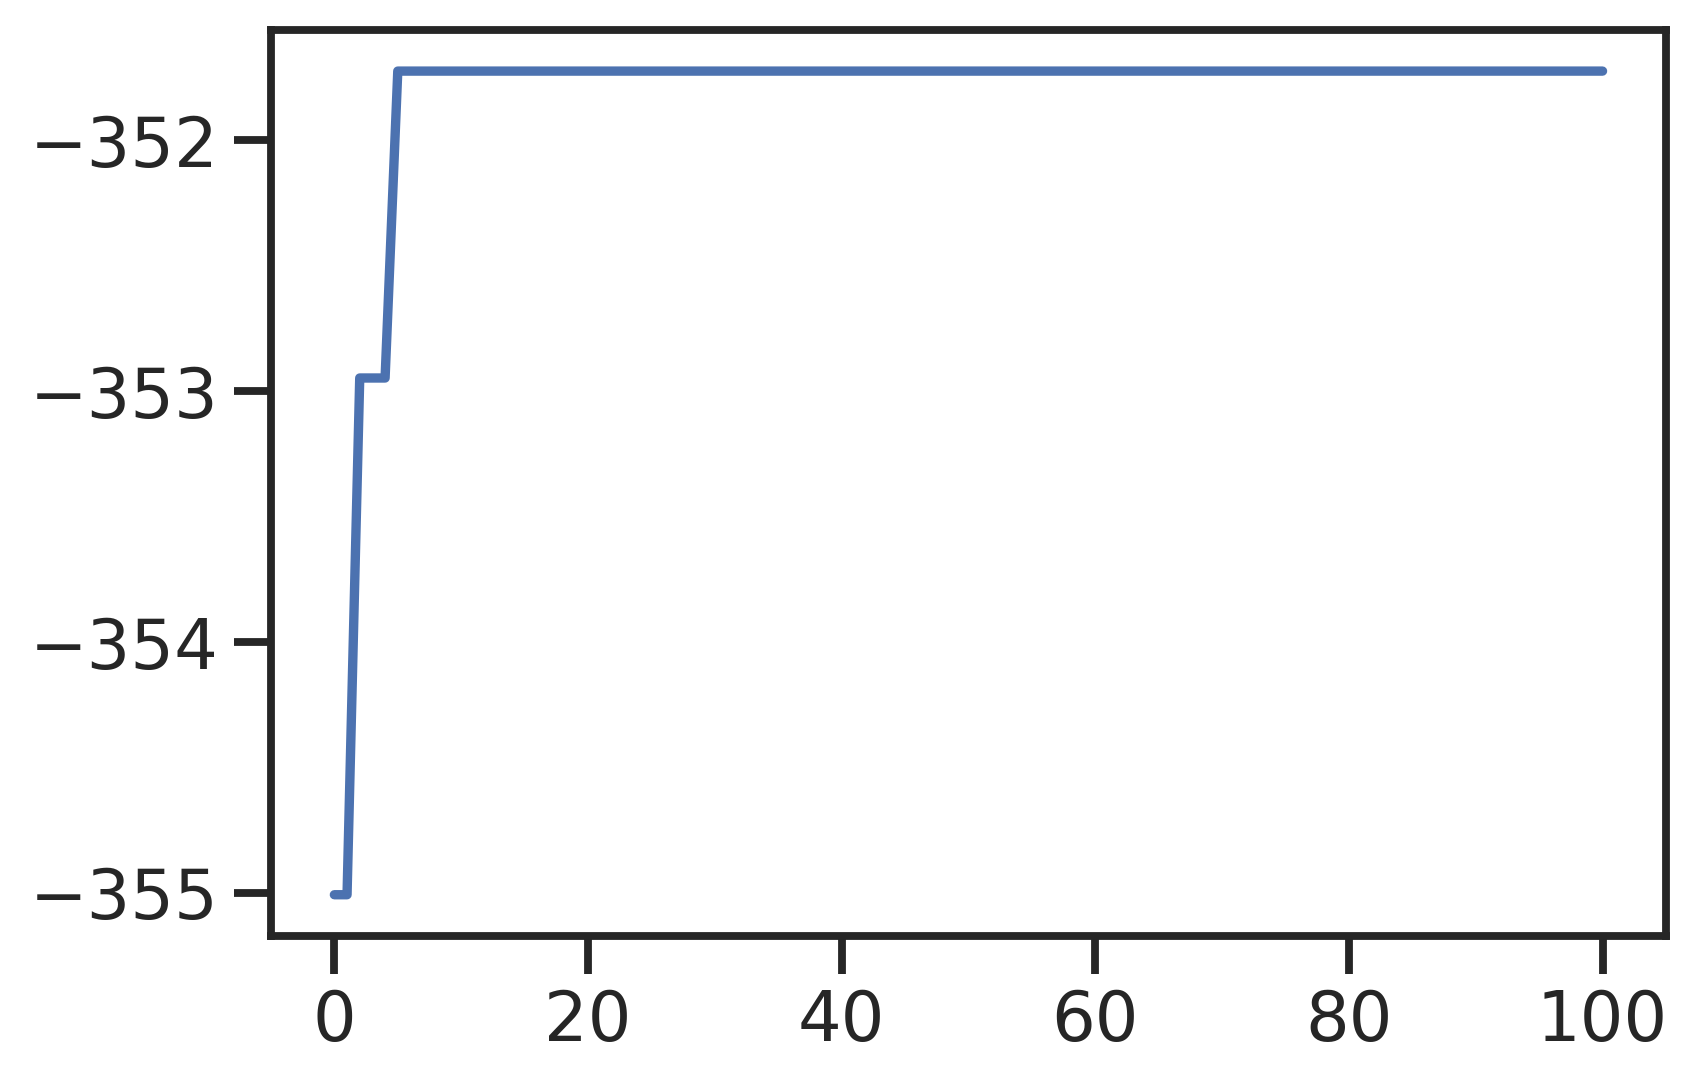

In [39]:
plt.plot(gao.best_fitness_per_generation)

In [40]:
AIC_ps = 2*len(fit_parms) + fit_cost
AIC_ps

355.7248815517577

In [41]:
fragments = particle_split(sample_sizes, fit_parms[0], int(fit_parms[1]))
frag_freq = fragment_frequency(fragments)

(0, 25)

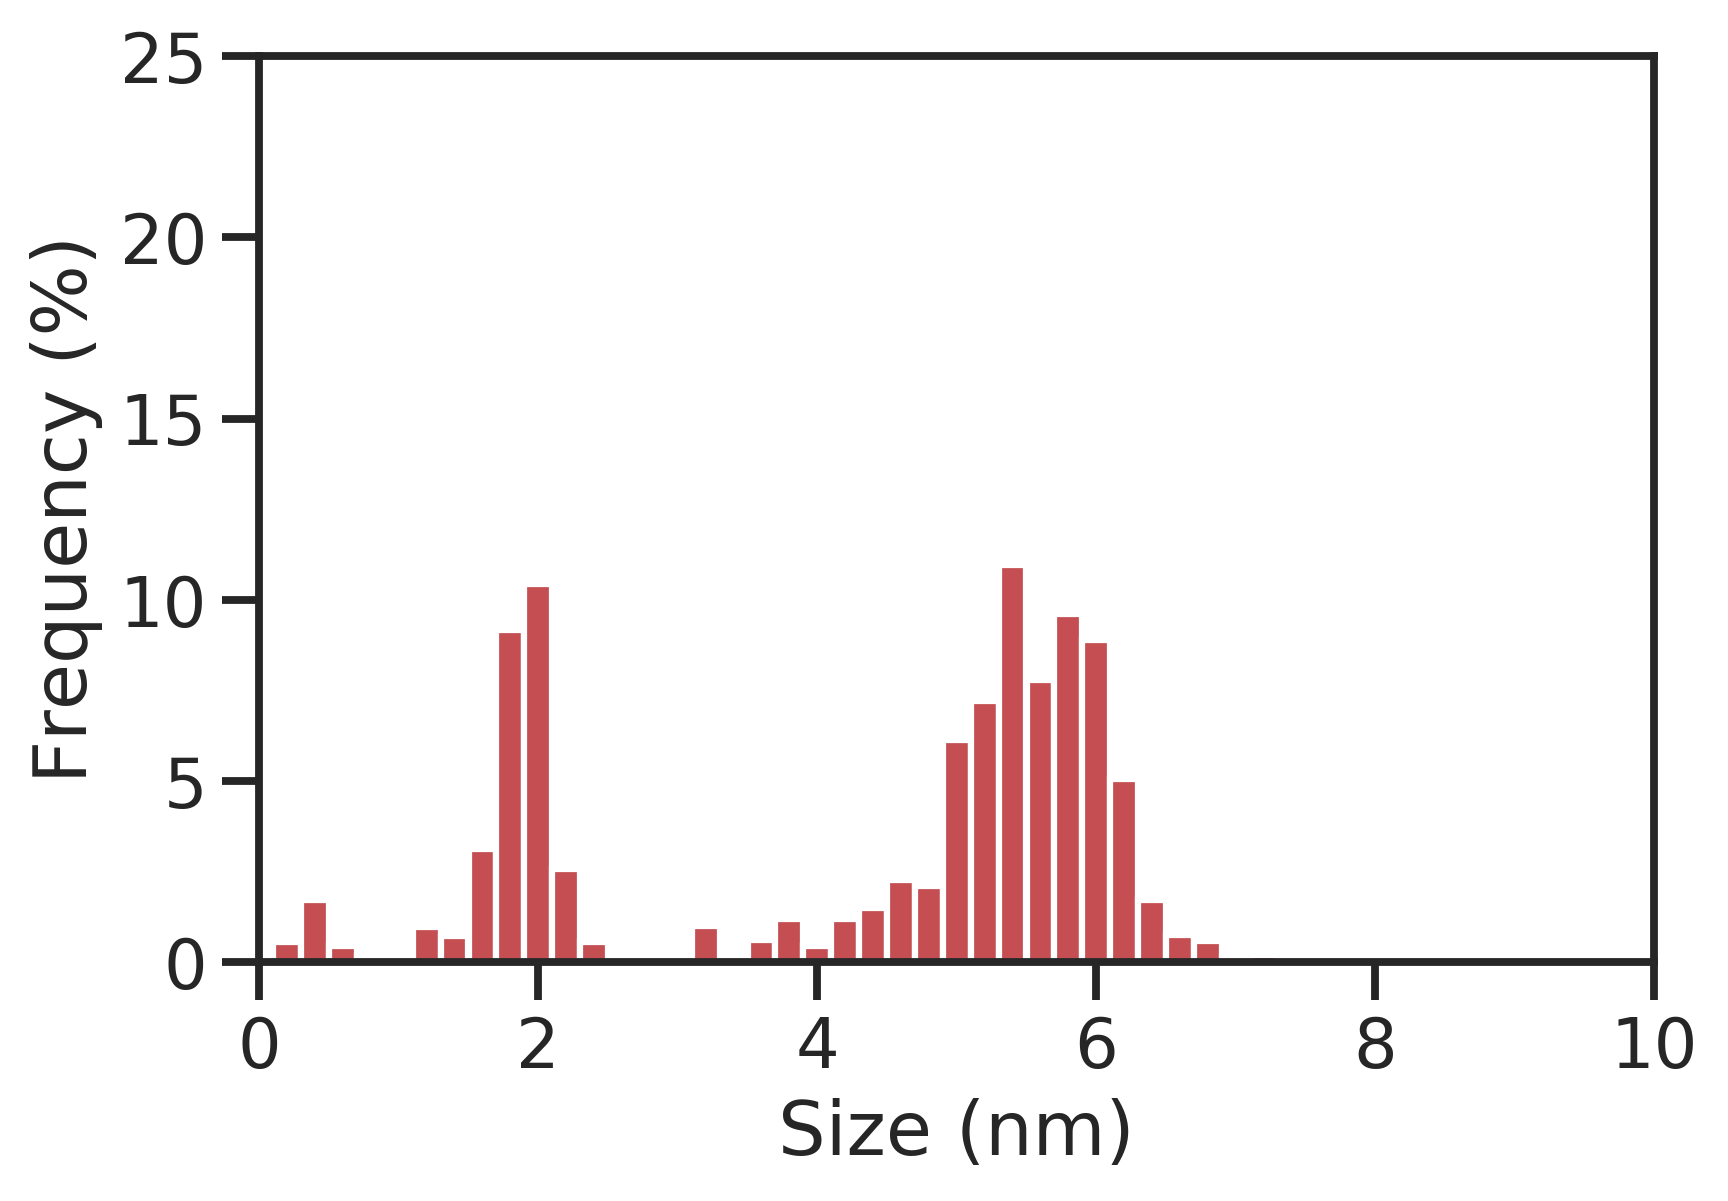

In [42]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

In [43]:
np.savetxt('5nm_nlsfit_moreTEM_frequency_ps.txt', frag_freq)

Text(1, 22, 'SSE=352')

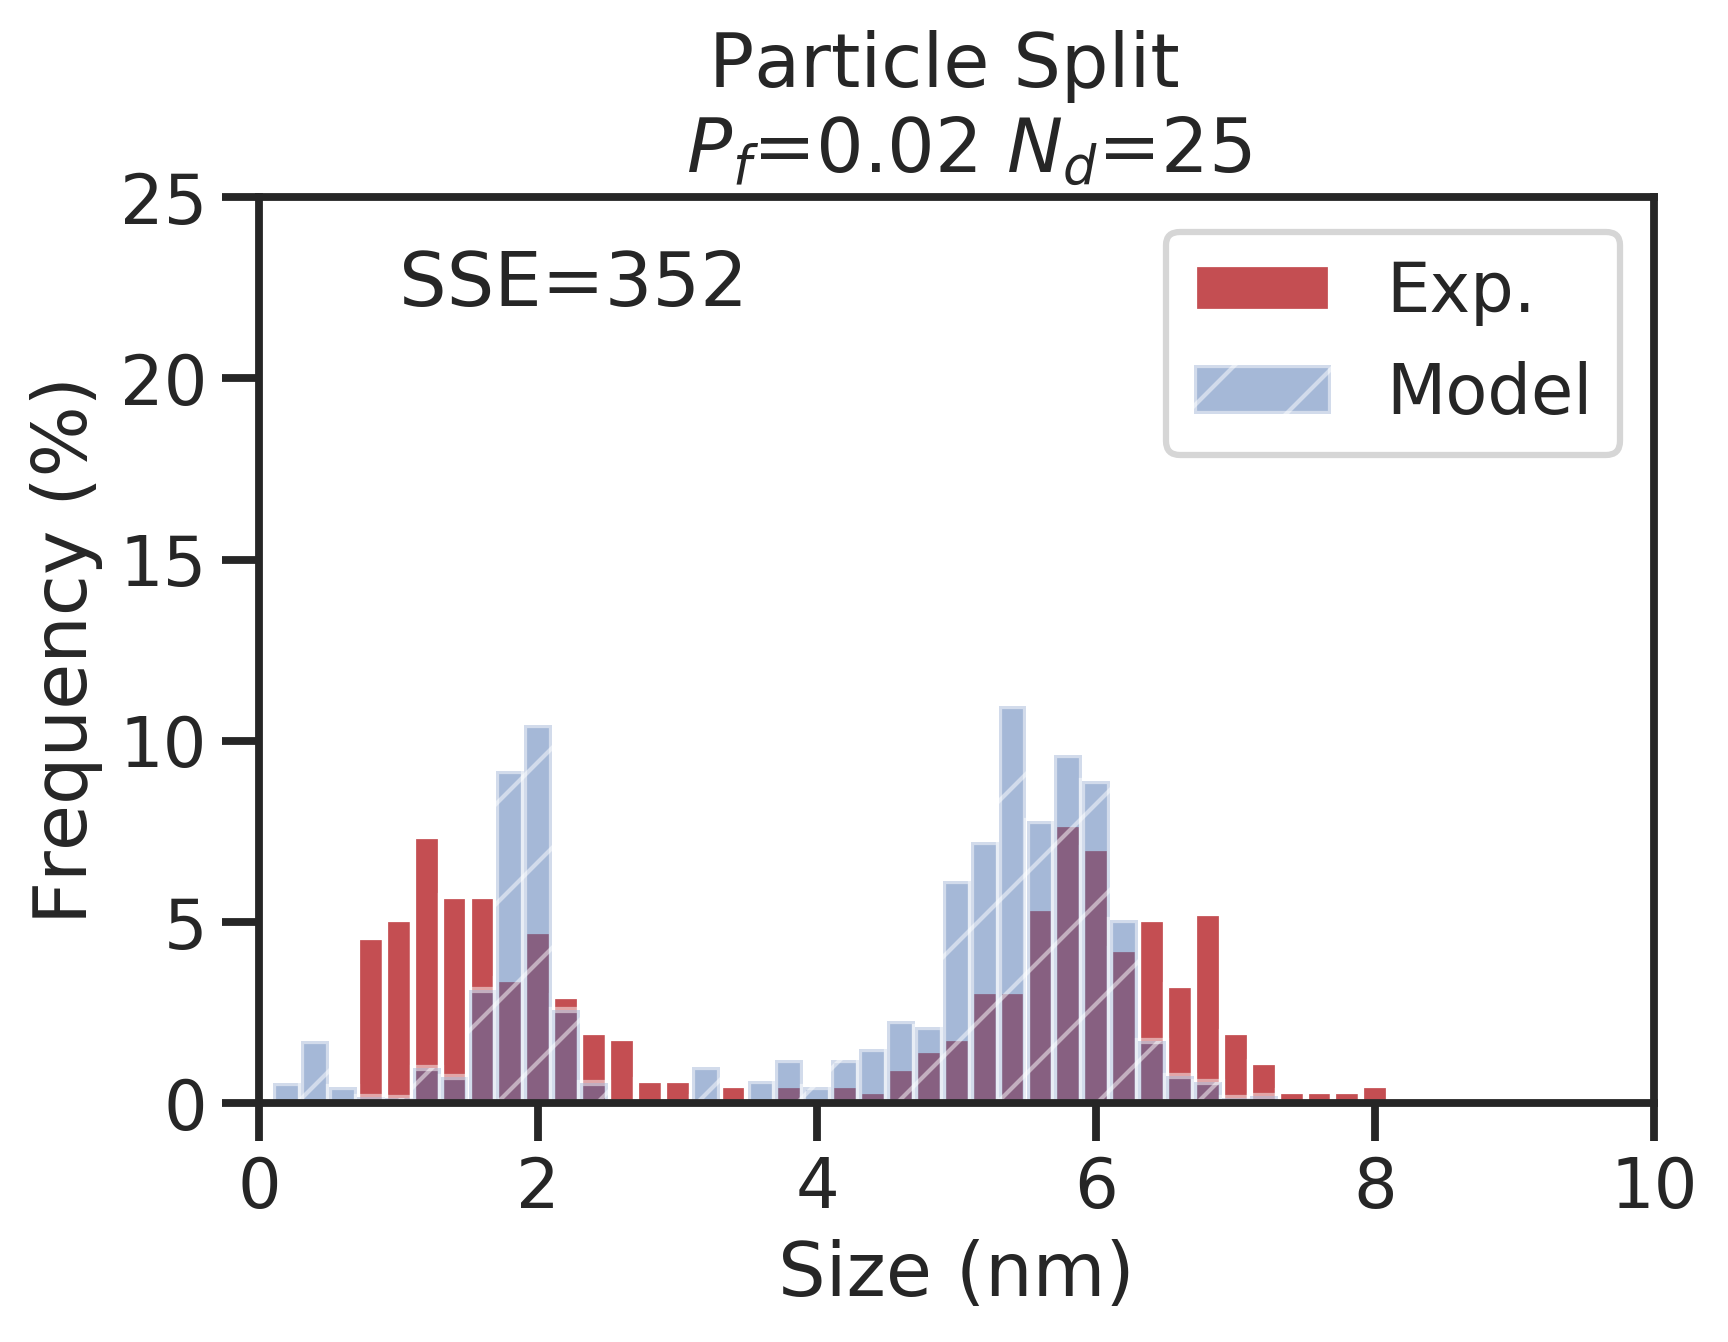

In [44]:
plt.hist(centers, bins=edges, weights=dist['laser_low'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))
plt.title("Particle Split \n $P_f$={:.2f} $N_d$={}".format(fit_parms[0], int(fit_parms[1])))
plt.text(1,22, "SSE={:.0f}".format(fit_cost))

## Surface Layer Ablation, Unequal - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [45]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [46]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [47]:
#nrepeats = 3
# Set the active point population size
population_size = 1000
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation_unequal, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

Generations:  65%|██████▌   | 65/100 [18:53<10:10, 17.44s/it] 


KeyboardInterrupt: 

In [ ]:
plt.plot(gao.best_fitness_per_generation)

In [ ]:
AIC_sa_ue = 2*len(fit_parms) + fit_cost
AIC_sa_ue

In [ ]:
fragments = surface_ablation_unequal(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

In [ ]:
#plt.hist(centers, bins=edges, weights=frag_freq, color='r')
#plt.xlim((0,10))
#plt.ylabel("Frequency (%)")
#plt.xlabel("Size (nm)")
#plt.ylim((0,25))

In [ ]:
plt.hist(centers, bins=edges, weights=dist['laser_low'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(1,22, "SSE={:.0f}".format(fit_cost))

----

# 15 nm

In [48]:
# Load the data
dist = pd.read_csv('15nm_distribution_moreparticles.csv')
dist.head()

,size,initial,laser_low,laser_high
0,2.0,0.0,0.675676,0.000000
1,2.5,0.0,4.054054,0.000000
2,3.0,0.0,14.189189,9.411765
3,3.5,0.0,12.837838,9.803922
4,4.0,0.0,12.162162,13.725490


In [49]:
# Get the histogram bin centers
centers = dist['size'].to_numpy()
centers

array([ 2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,
        7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5,
       13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. ,
       18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5,
       24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5, 29. ,
       29.5, 30. ])

In [50]:
# Histogram bin width
bw = centers[1] - centers[0]
bw

0.5

In [51]:
# Create the corresponding edges for the histogram
edges = np.linspace(centers[0] - 0.5*bw, centers[-1] + 0.5*bw, len(centers)+1, endpoint=True)
edges

array([ 1.75,  2.25,  2.75,  3.25,  3.75,  4.25,  4.75,  5.25,  5.75,
        6.25,  6.75,  7.25,  7.75,  8.25,  8.75,  9.25,  9.75, 10.25,
       10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75,
       15.25, 15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25,
       19.75, 20.25, 20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75,
       24.25, 24.75, 25.25, 25.75, 26.25, 26.75, 27.25, 27.75, 28.25,
       28.75, 29.25, 29.75, 30.25])

In [52]:
# Create a distribution object from the histogrammed frequencies.
rv_initial = rv_histogram((dist['initial'].to_numpy(), edges))
rv_initial

In [53]:
sample_sizes = rv_initial.rvs(size=10000, random_state=14983)
sample_sizes[:10]

array([16.14422844, 15.98028935, 14.04770798, 16.66424477, 15.50495613,
       17.869869  , 14.05021566, 15.21996199, 15.41745288, 16.78161428])

[0. 0. 0. 0. 0.]


(0, 60)

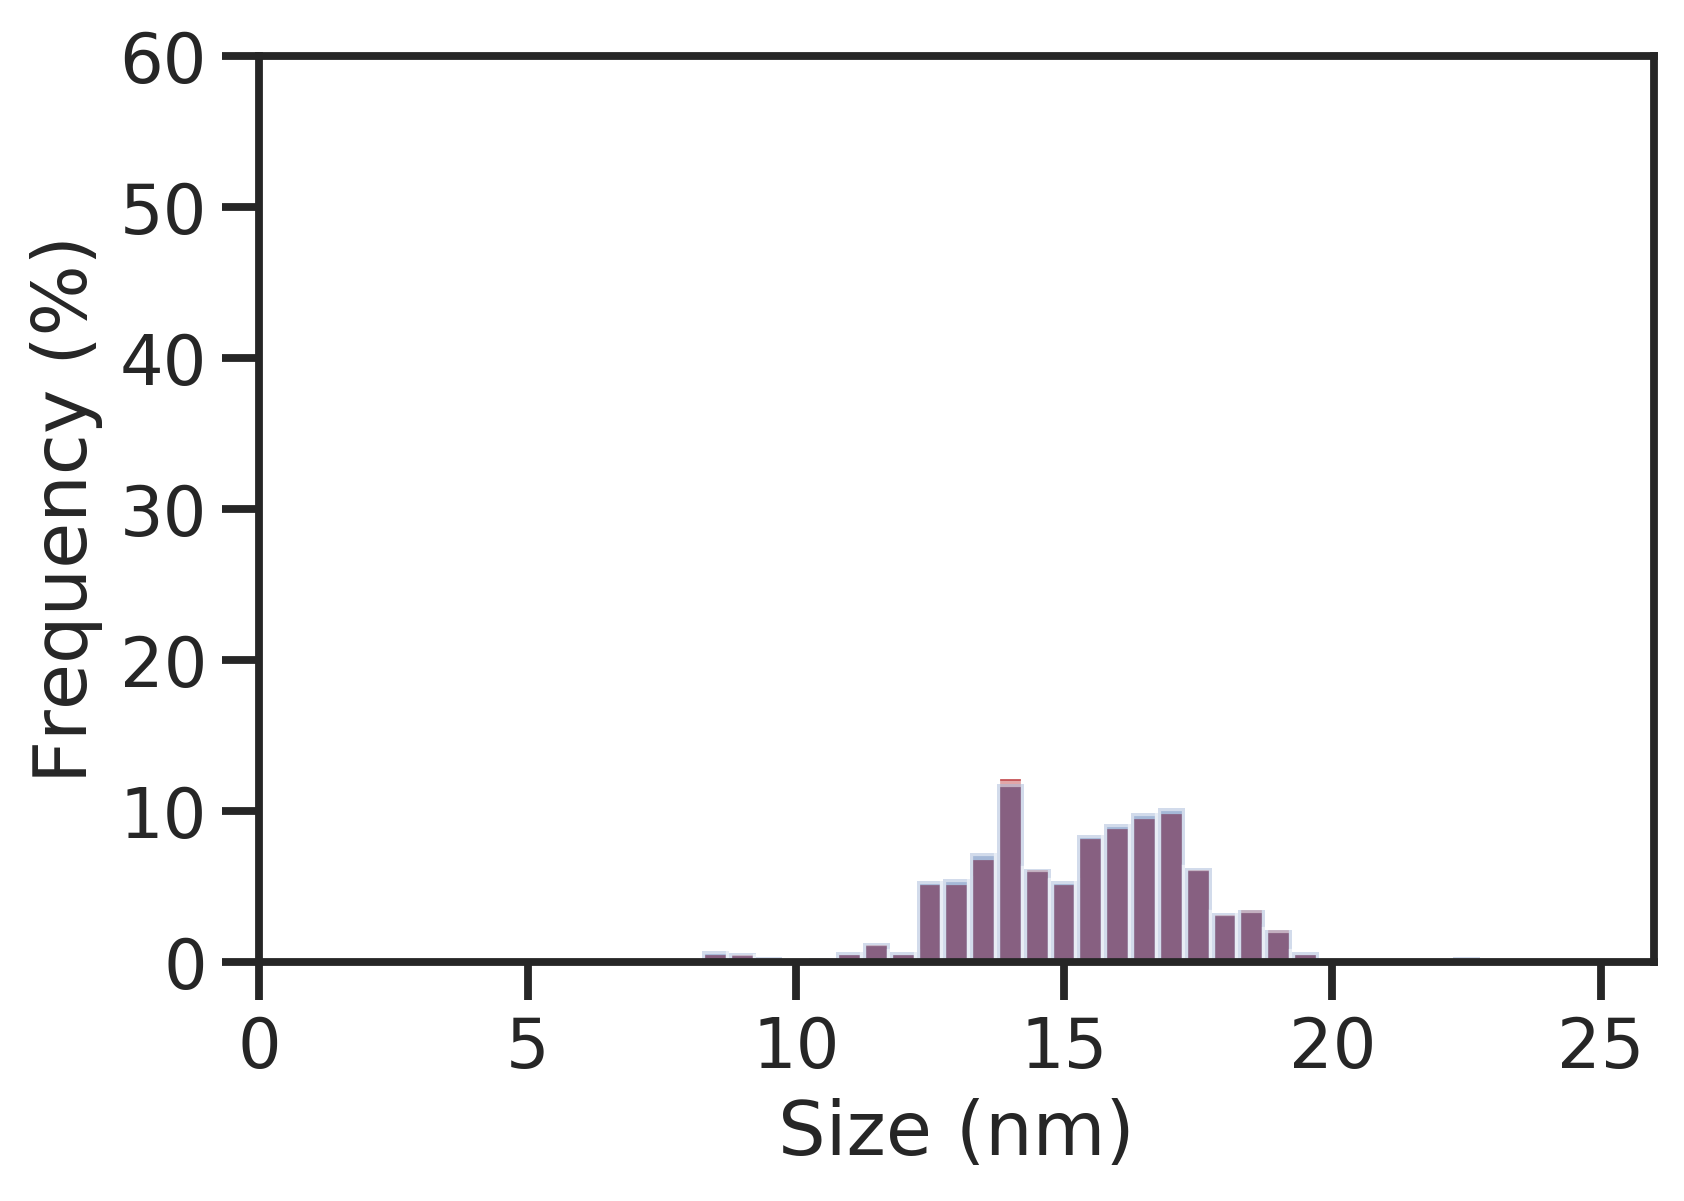

In [54]:
counts, _edges = np.histogram(sample_sizes, bins=edges)

freq = 100 * counts / len(sample_sizes)
print(freq[:5])
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.hist(centers, bins=edges, weights=freq, color='b', alpha=0.5)
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

(0, 60)

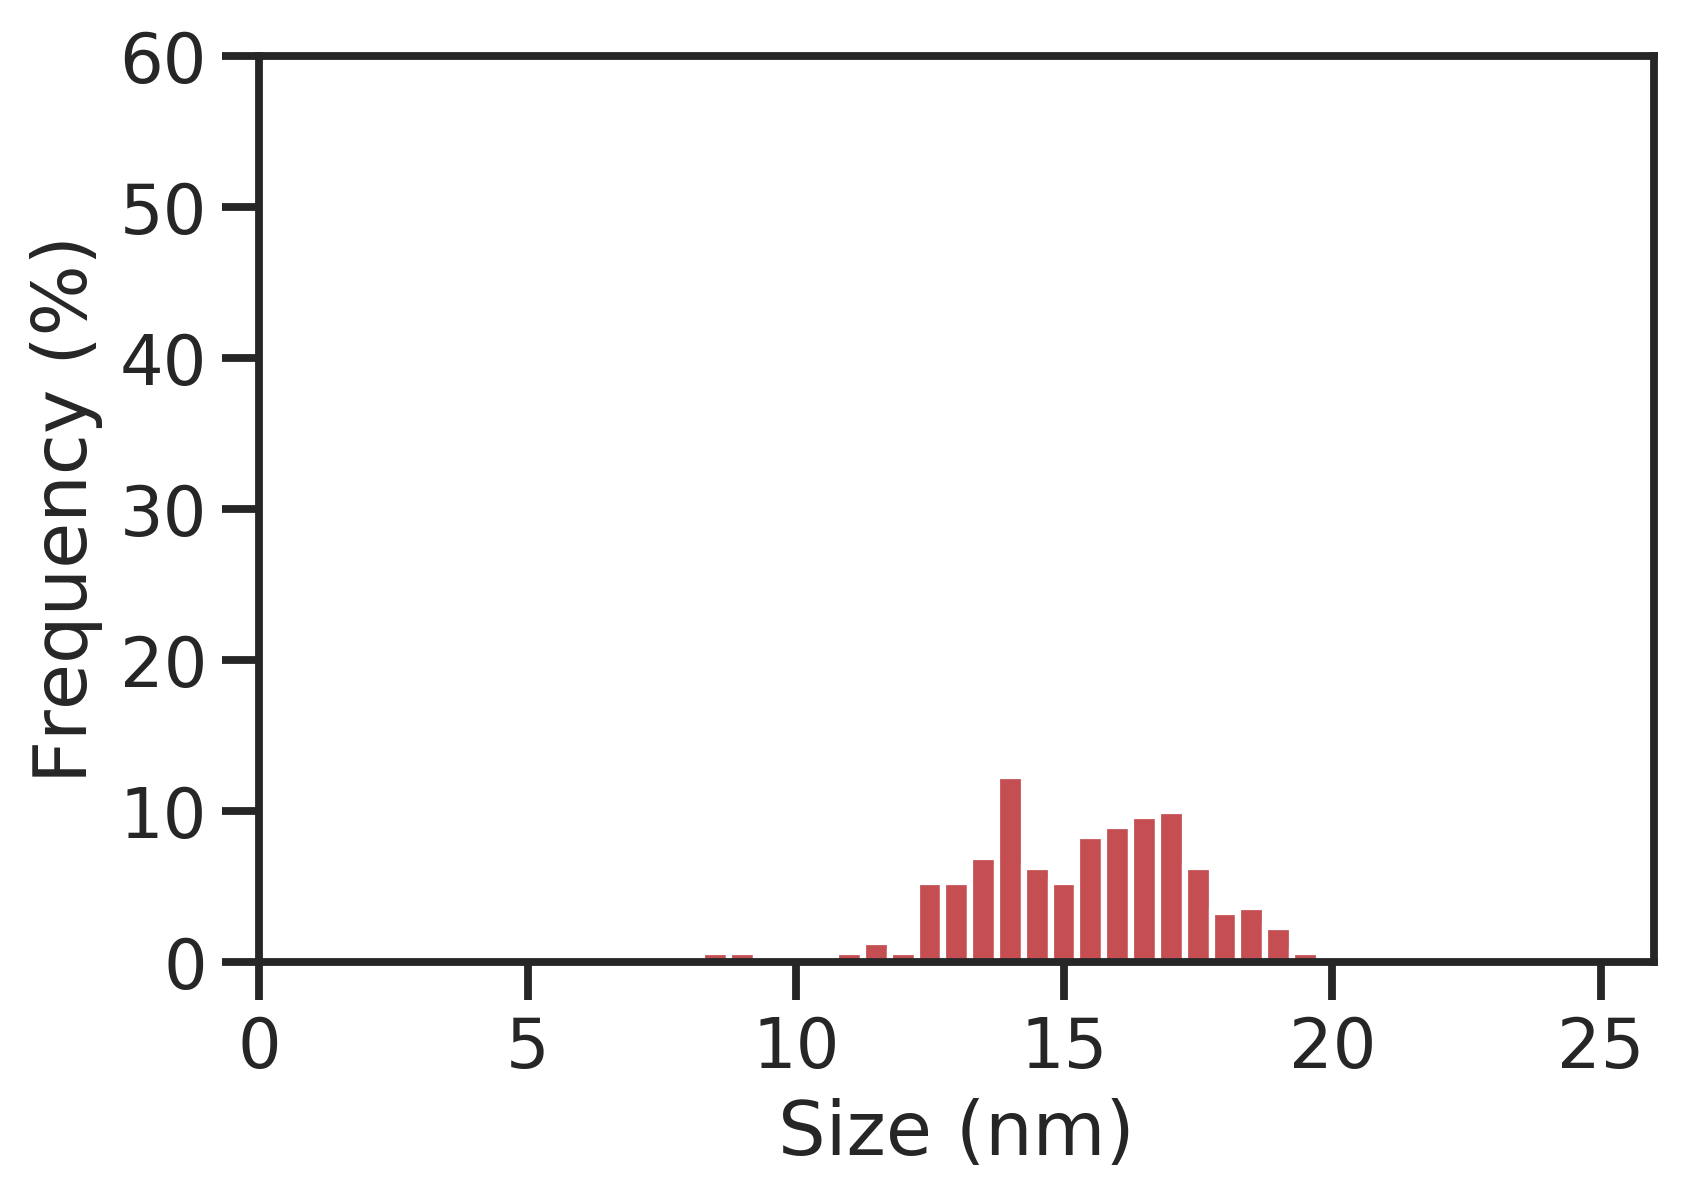

In [55]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

## Surface Layer Ablation - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [56]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [57]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [58]:
#nrepeats = 3
# Set the active point population size
population_size = 1000
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

Generations: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


[ 0.05580808  0.07792082 18.46826951] 254.67266787209294


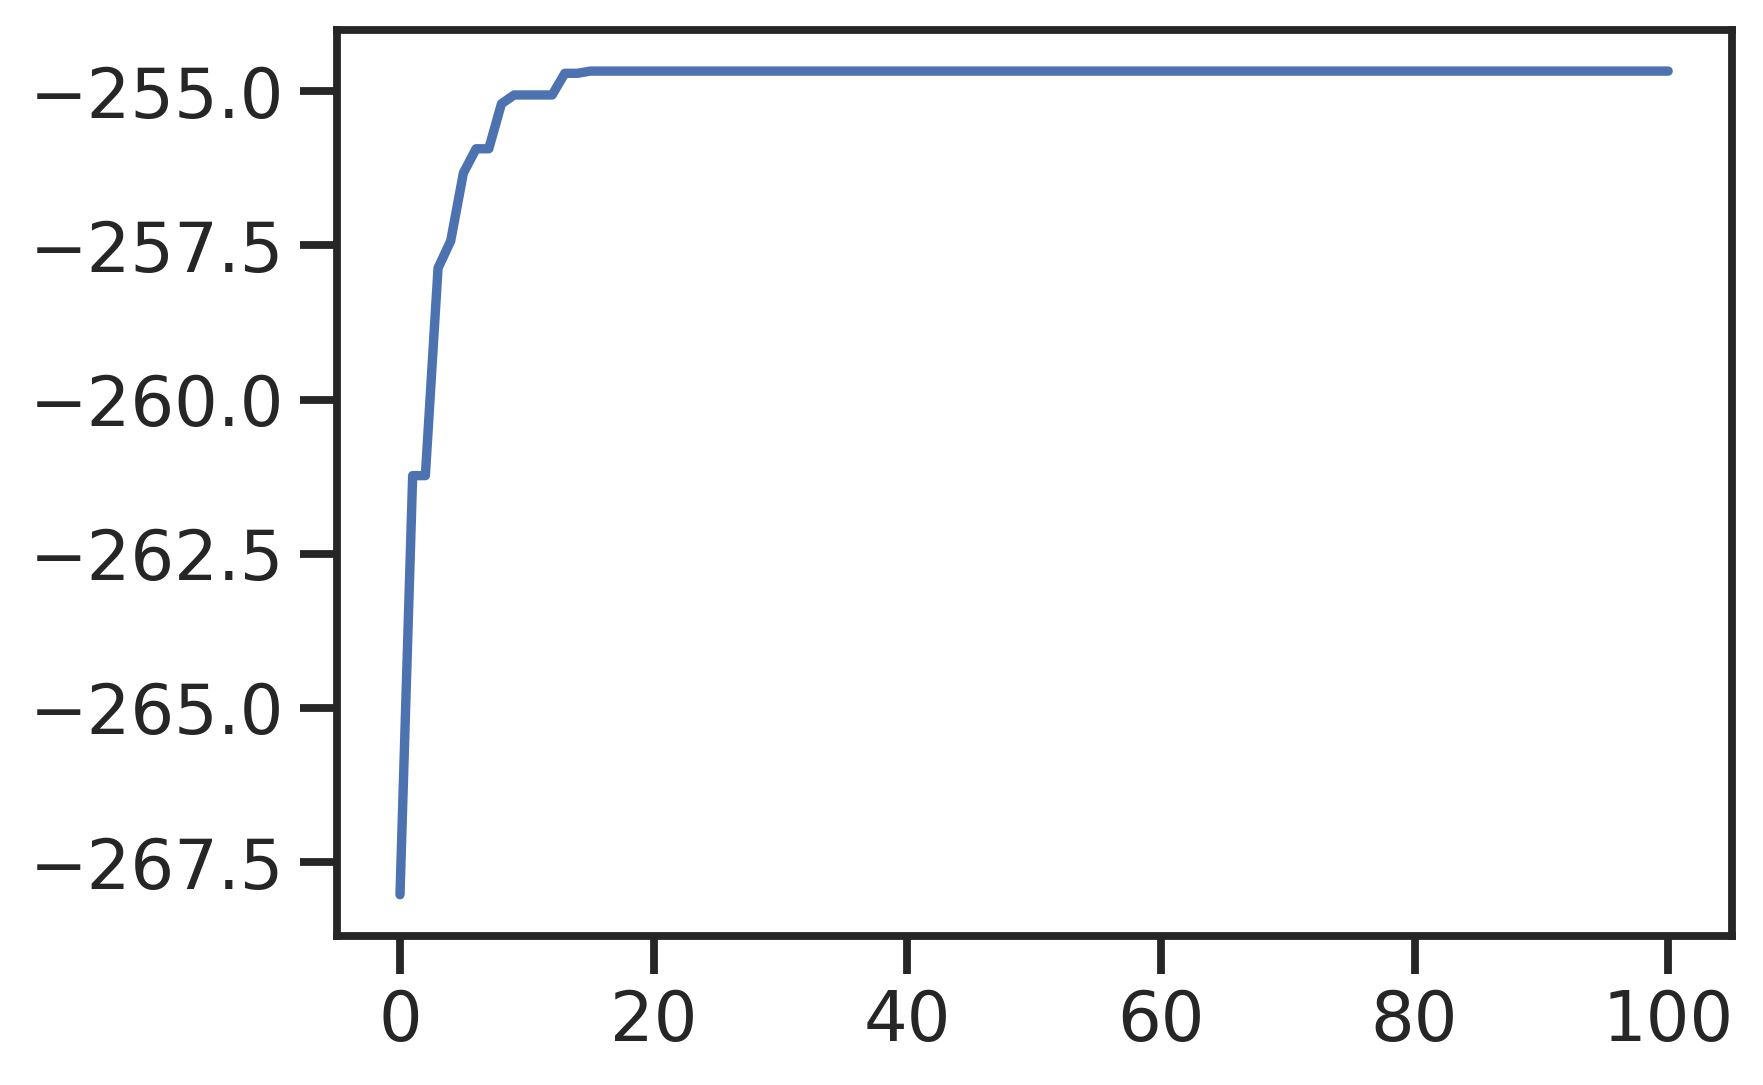

In [59]:
plt.plot(gao.best_fitness_per_generation)

In [60]:
AIC_sa = 2*len(fit_parms) + fit_cost
AIC_sa

260.6726678720929

In [61]:
fragments = surface_ablation(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

(0, 60)

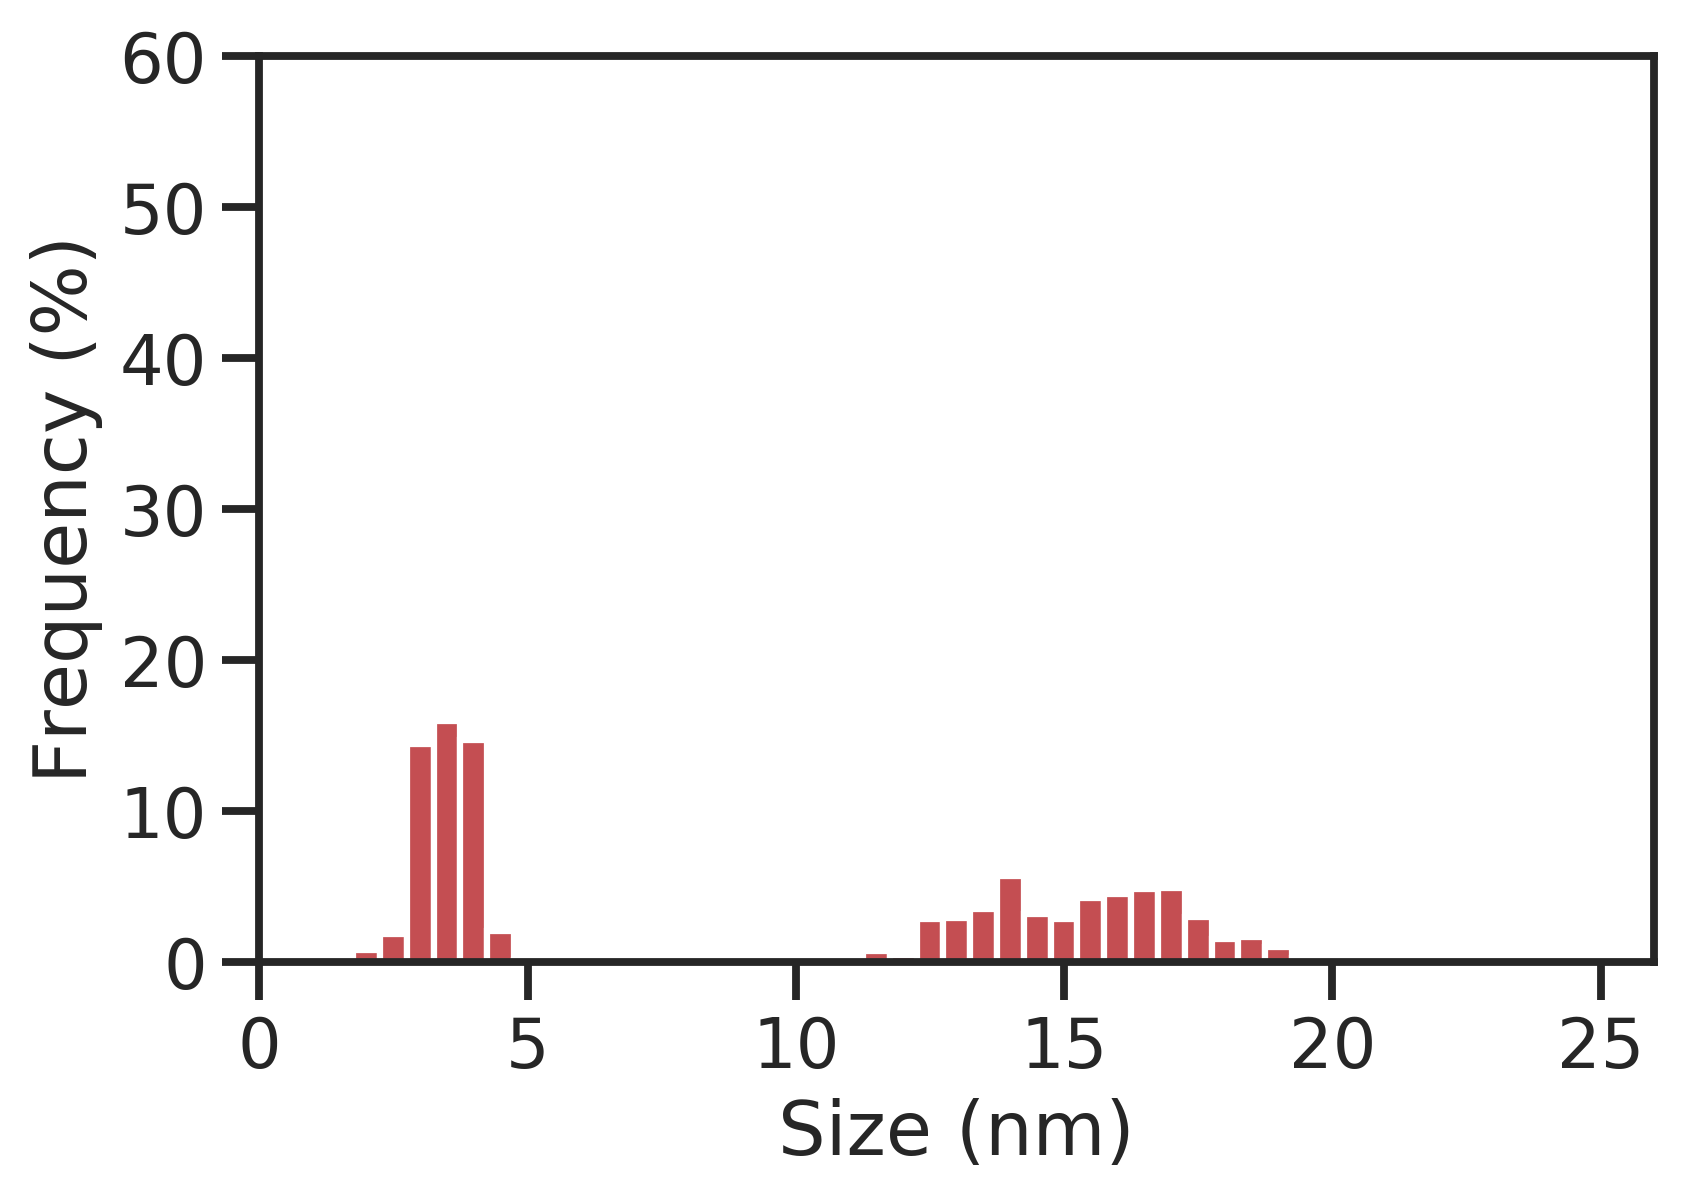

In [62]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

In [63]:
np.savetxt('15nm_nlsfit_moreTEM_centers.txt', centers)
np.savetxt('15nm_nlsfit_moreTEM_edges.txt', edges)
np.savetxt('15nm_nlsfit_moreTEM_frequency_sa.txt', frag_freq)

In [64]:
fit_parms

array([ 0.05580808,  0.07792082, 18.46826951])

Text(3, 52, 'SSE=255')

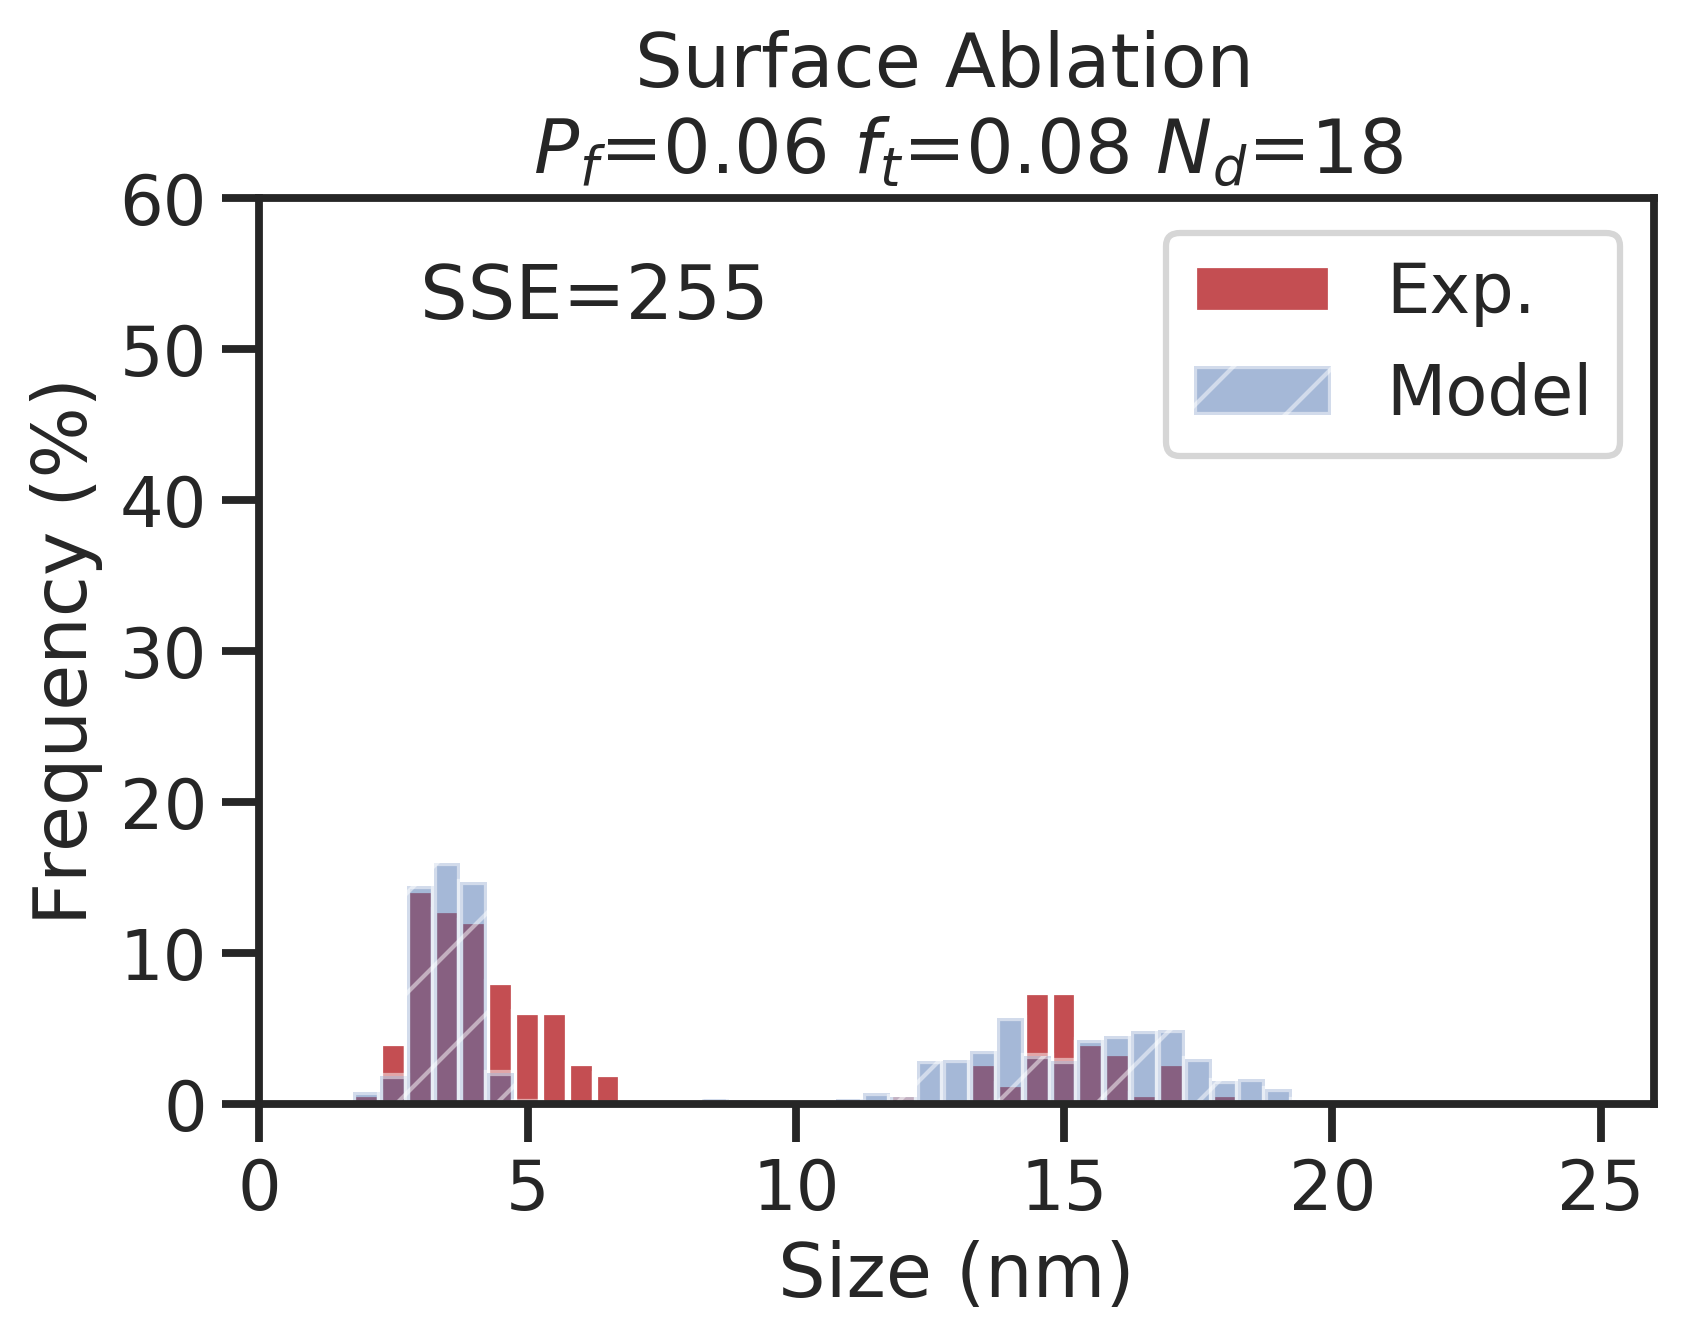

In [65]:
plt.hist(centers, bins=edges, weights=dist['laser_low'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))
#plt.suptitle("Surface Ablation")
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(3,52, "SSE={:.0f}".format(fit_cost))

## Particle Split - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [66]:
# Set the active point population size
population_size = 1000
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_ps, fitness_particle_split, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)

Generations: 100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


[1.14464497e-02 8.66840864e+01] 286.38146807104476


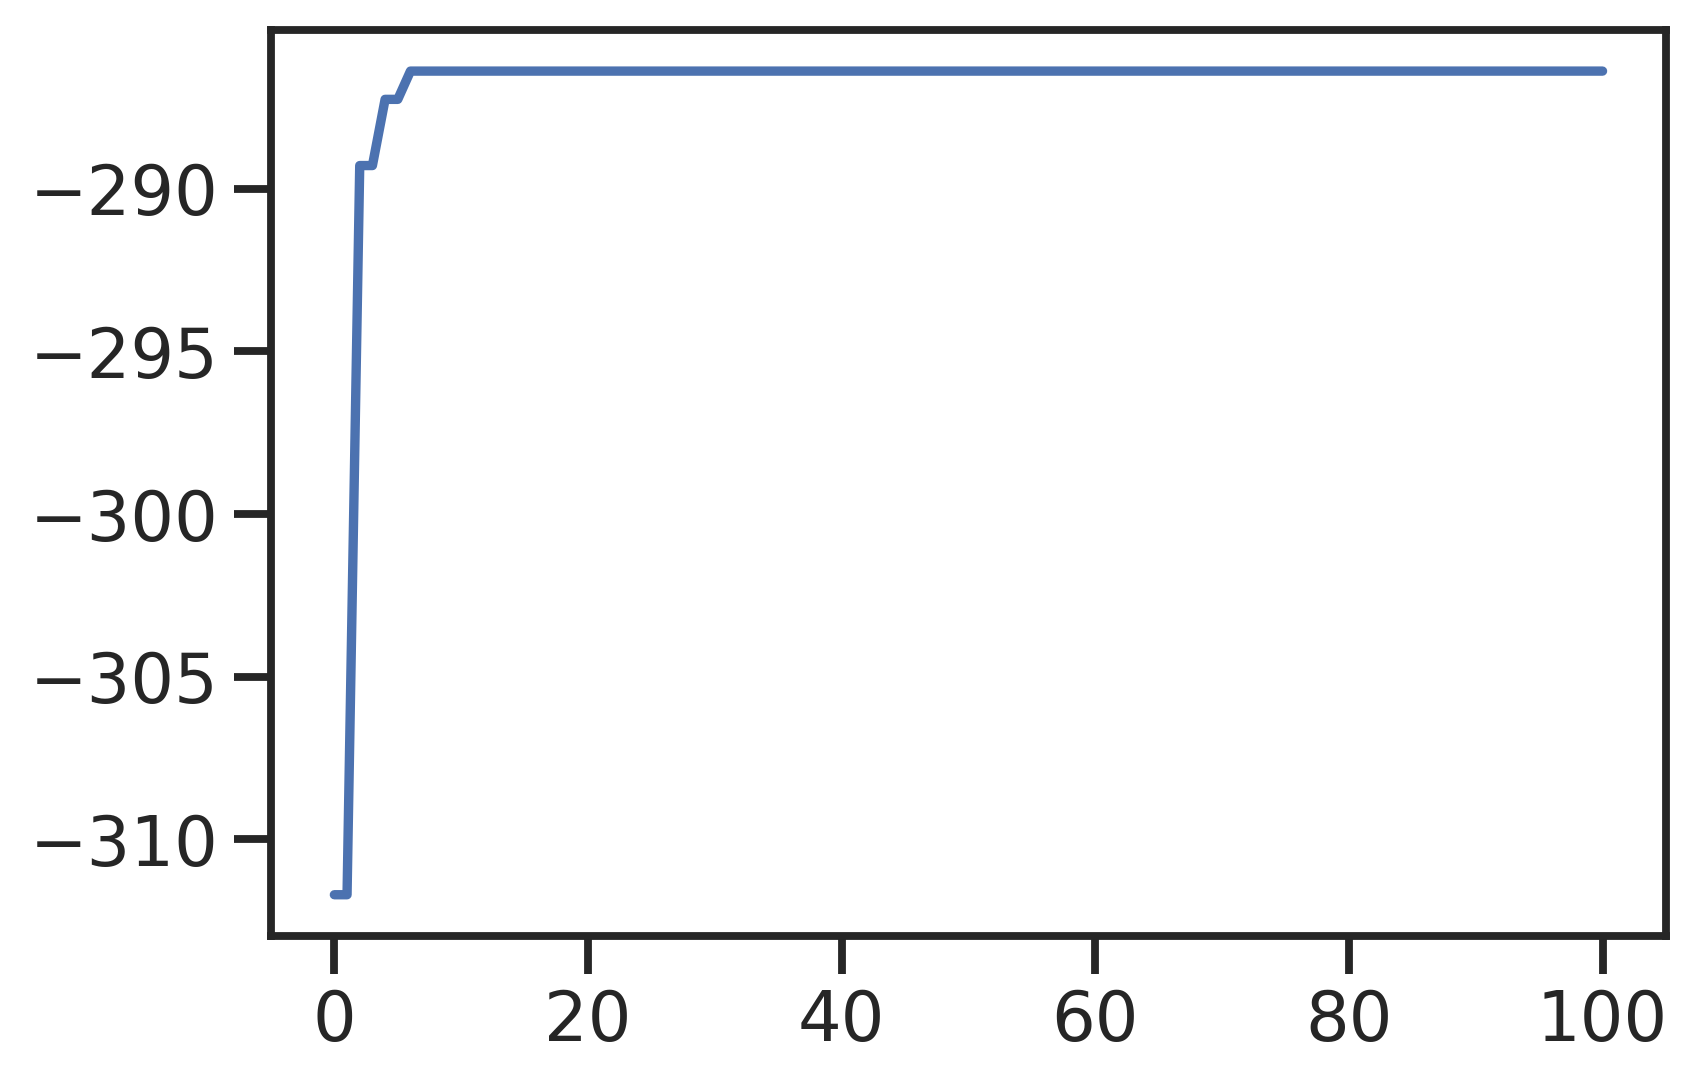

In [67]:
plt.plot(gao.best_fitness_per_generation)

In [68]:
AIC_ps = 2*len(fit_parms) + fit_cost
AIC_ps

290.38146807104476

In [69]:
fragments = particle_split(sample_sizes, fit_parms[0], int(fit_parms[1]))
frag_freq = fragment_frequency(fragments)

(0, 60)

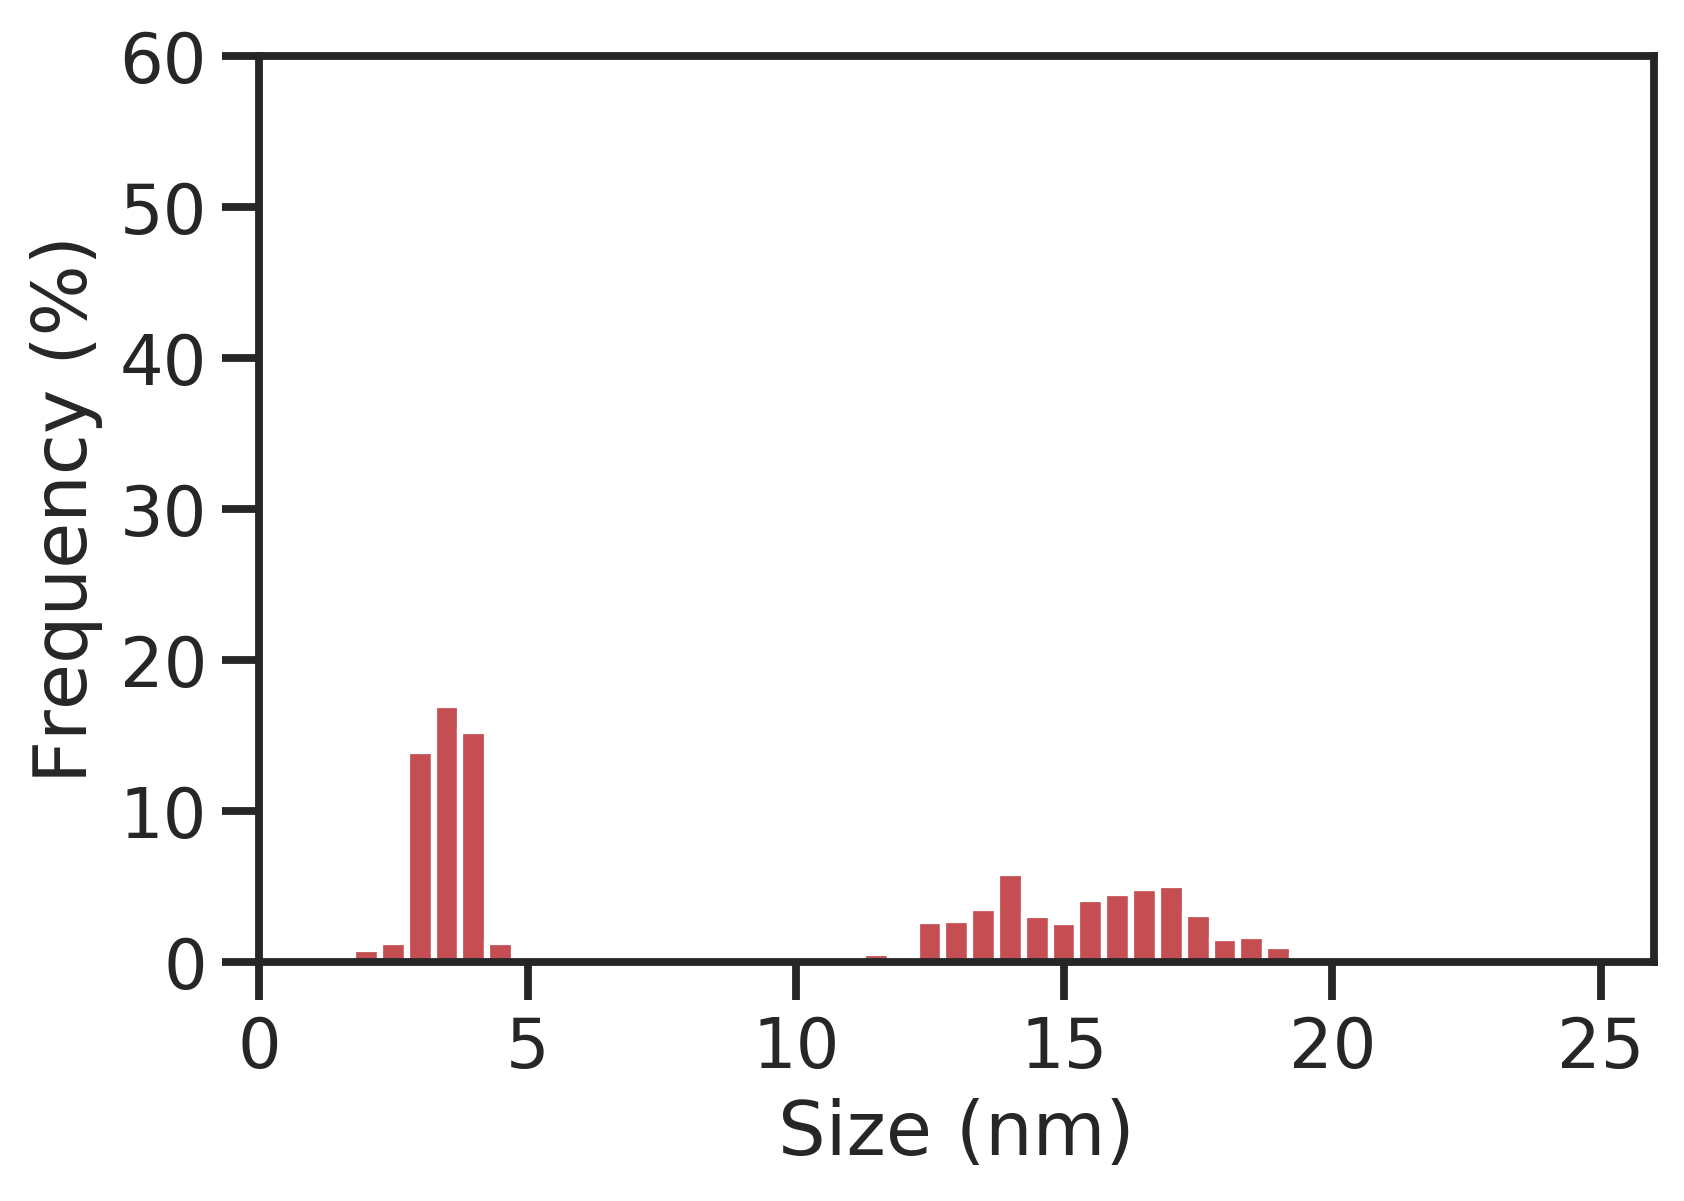

In [70]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

In [71]:
np.savetxt('15nm_nlsfit_moreTEM_frequency_ps.txt', frag_freq)

Text(3, 52, 'SSE=286')

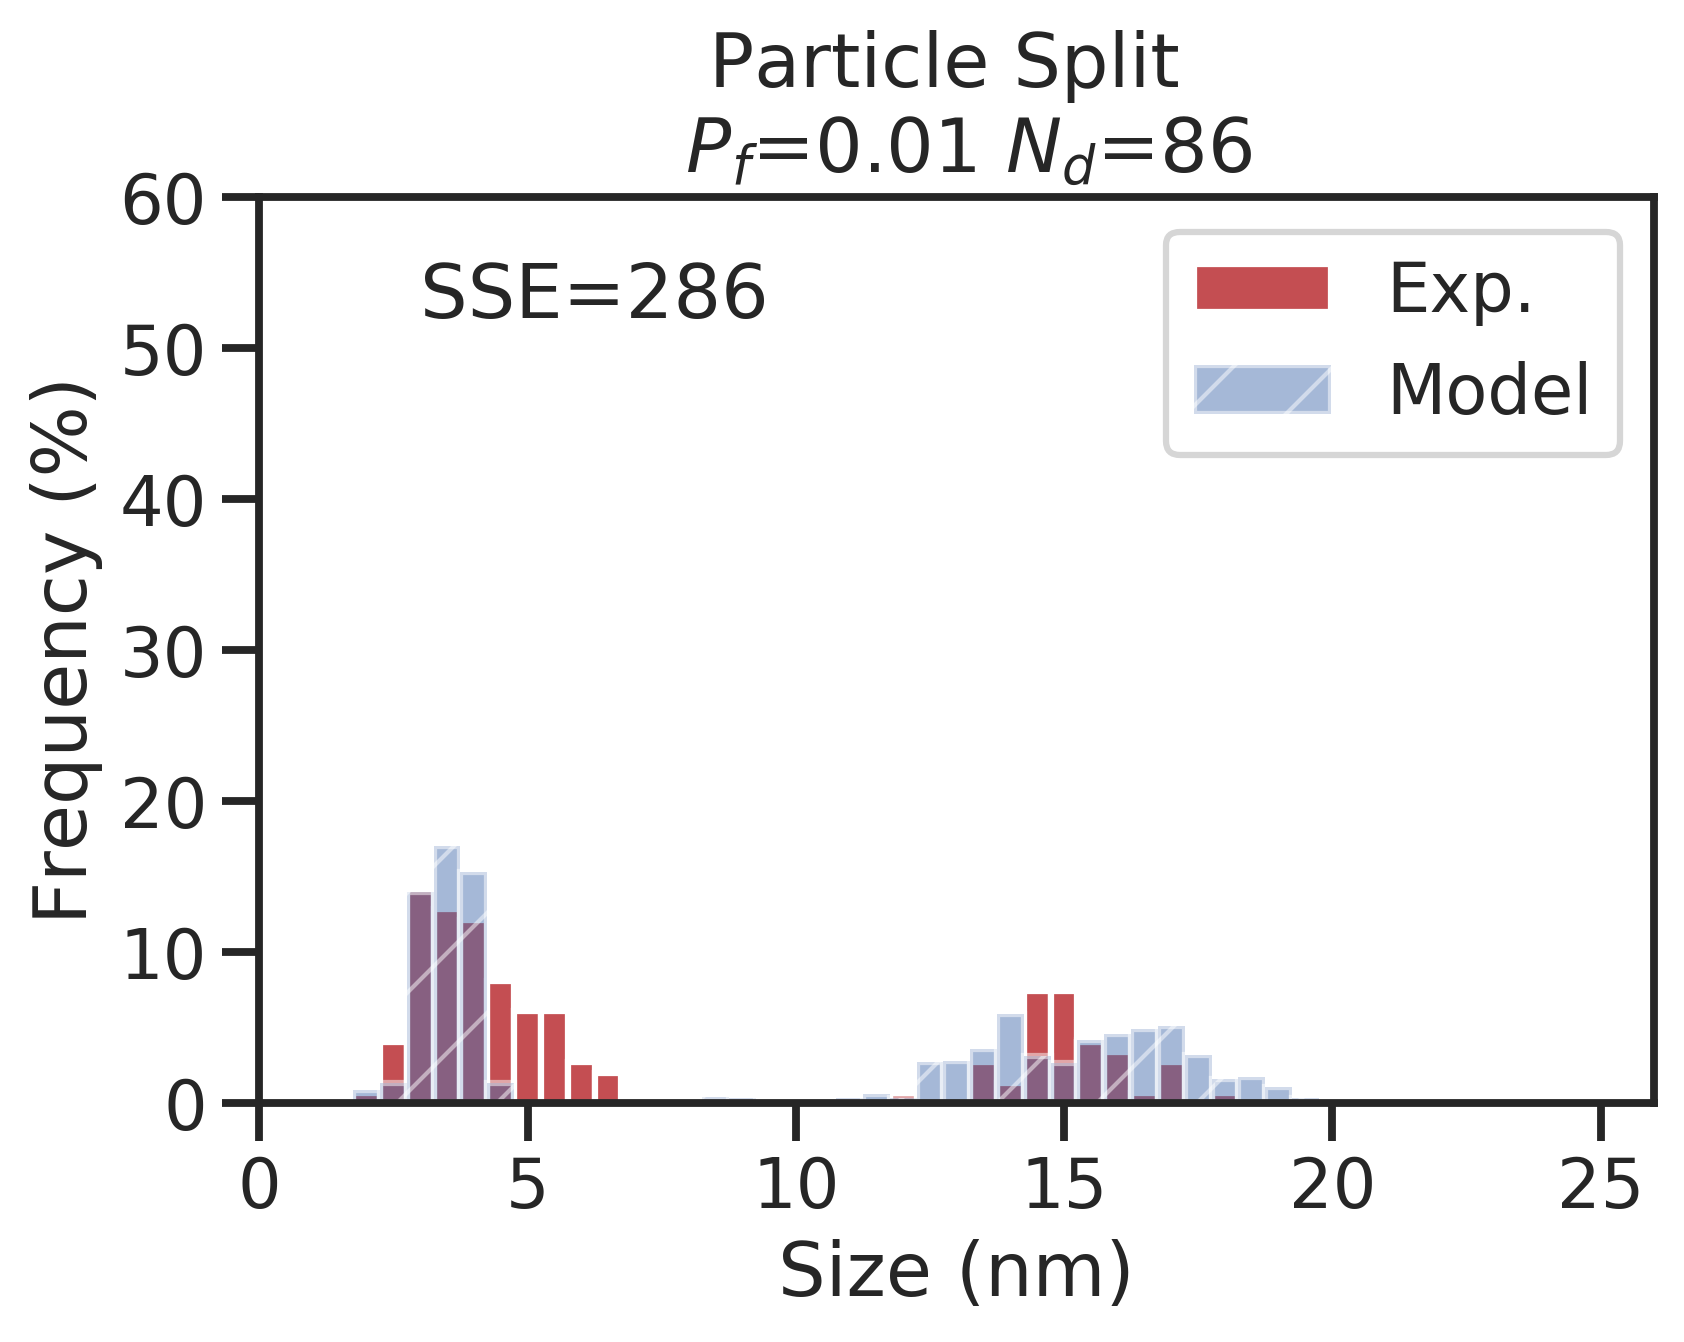

In [72]:
plt.hist(centers, bins=edges, weights=dist['laser_low'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))
plt.title("Particle Split \n $P_f$={:.2f} $N_d$={}".format(fit_parms[0], int(fit_parms[1])))
plt.text(3,52, "SSE={:.0f}".format(fit_cost))

# 100 nm

In [73]:
# Load the data
dist = pd.read_csv('100nm_distribution_moreparticles.csv')
dist.head()

,size,initial,laser_low,laser_high
0,5,0.0,0.196078,0.000000
1,10,0.0,38.235294,22.886598
2,15,0.0,20.980392,46.804124
3,20,0.0,8.039216,13.402062
4,25,0.0,5.686275,5.773196


In [74]:
# Get the histogram bin centers
centers = dist['size'].to_numpy()
centers

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170])

In [75]:
# Histogram bin width
bw = centers[1] - centers[0]
bw

5

In [76]:
# Create the corresponding edges for the histogram
edges = np.linspace(centers[0] - 0.5*bw, centers[-1] + 0.5*bw, len(centers)+1, endpoint=True)
edges

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5])

In [77]:
# Create a distribution object from the histogrammed frequencies.
rv_initial = rv_histogram((dist['initial'].to_numpy(), edges))
rv_initial

In [78]:
sample_sizes = rv_initial.rvs(size=10000, random_state=14983)
sample_sizes[:10]

array([106.41176504, 105.63588092,  96.29944521, 109.75768801,
       103.4721497 , 119.14463049,  96.31758572, 102.16742875,
       103.08869436, 110.65322279])

[0. 0. 0. 0. 0.]


(0, 30)

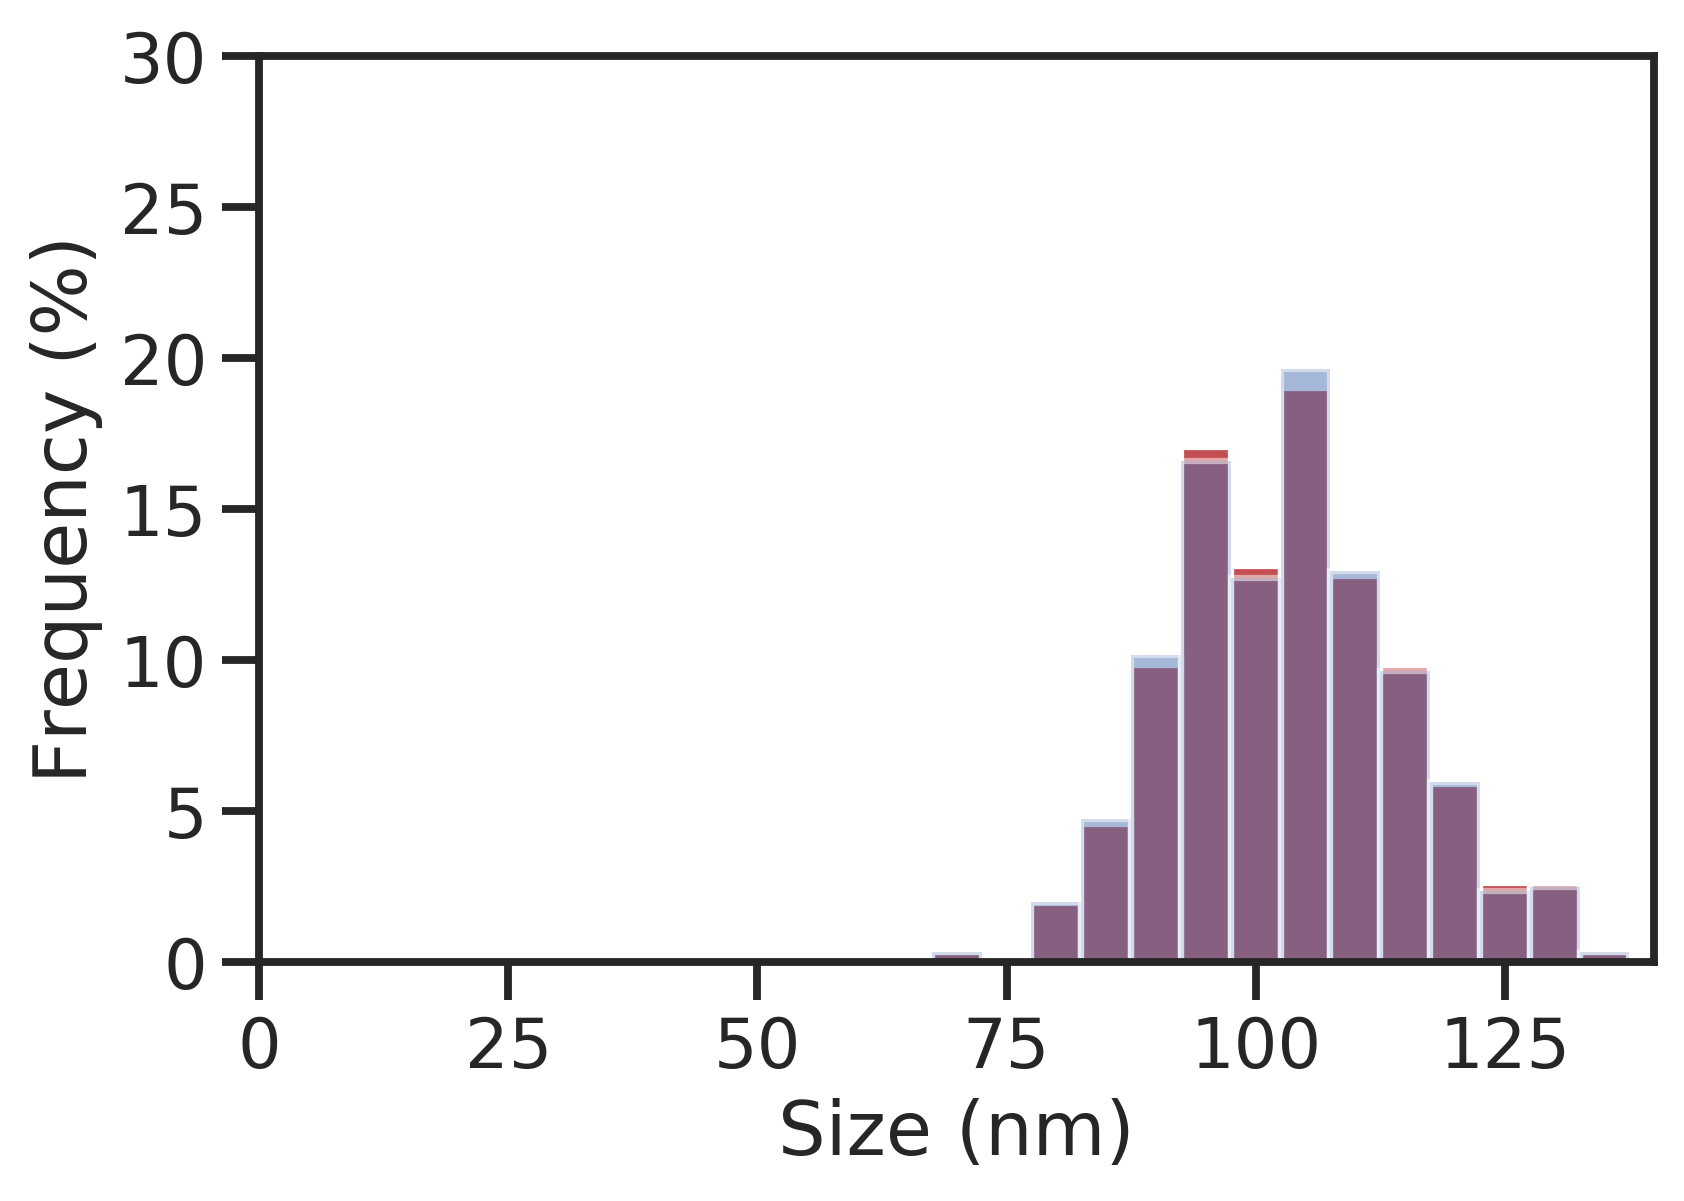

In [79]:
counts, _edges = np.histogram(sample_sizes, bins=edges)

freq = 100 * counts / len(sample_sizes)
print(freq[:5])
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.hist(centers, bins=edges, weights=freq, color='b', alpha=0.5)
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,30))

(0, 50)

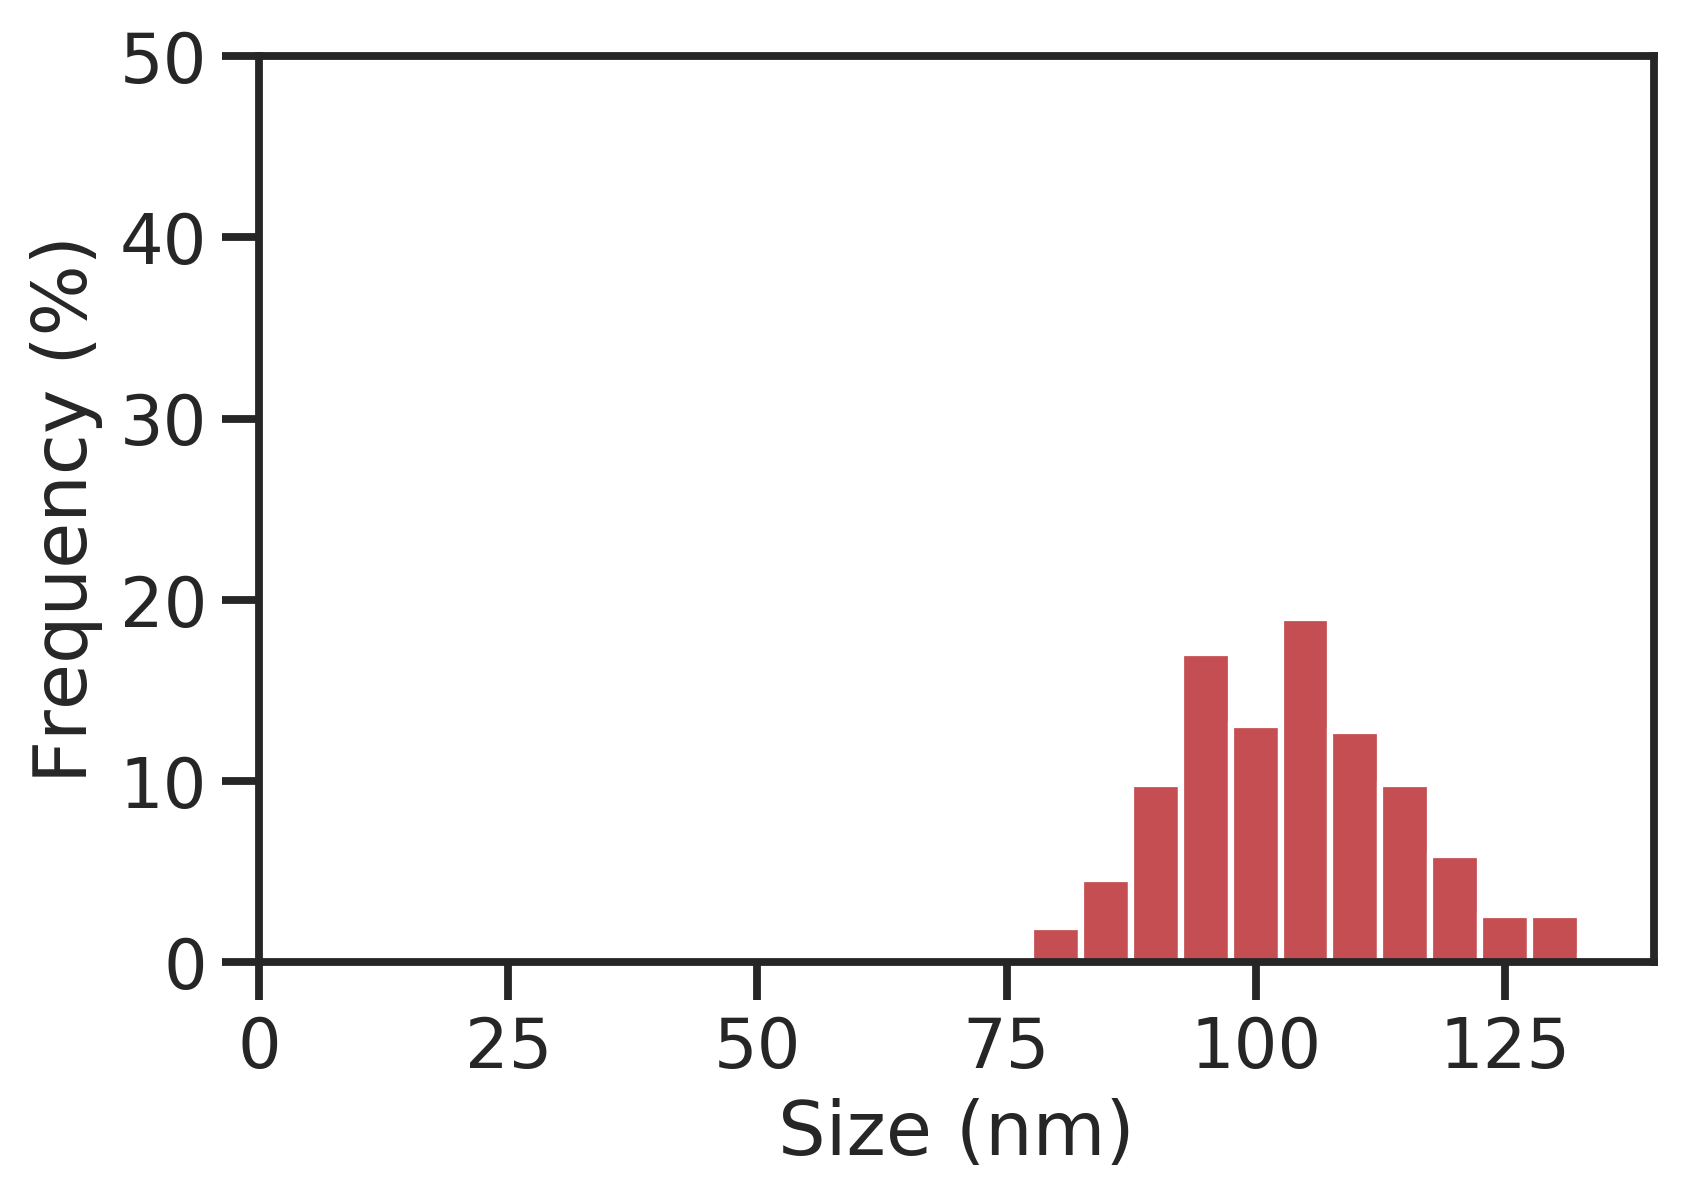

In [80]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,50))

## Surface Layer Ablation - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [81]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [82]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [83]:
#nrepeats = 3
# Set the active point population size
population_size = 1000
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

Generations: 100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


[1.13510670e-02 8.64632483e-02 1.51105098e+02] 145.54373352381978


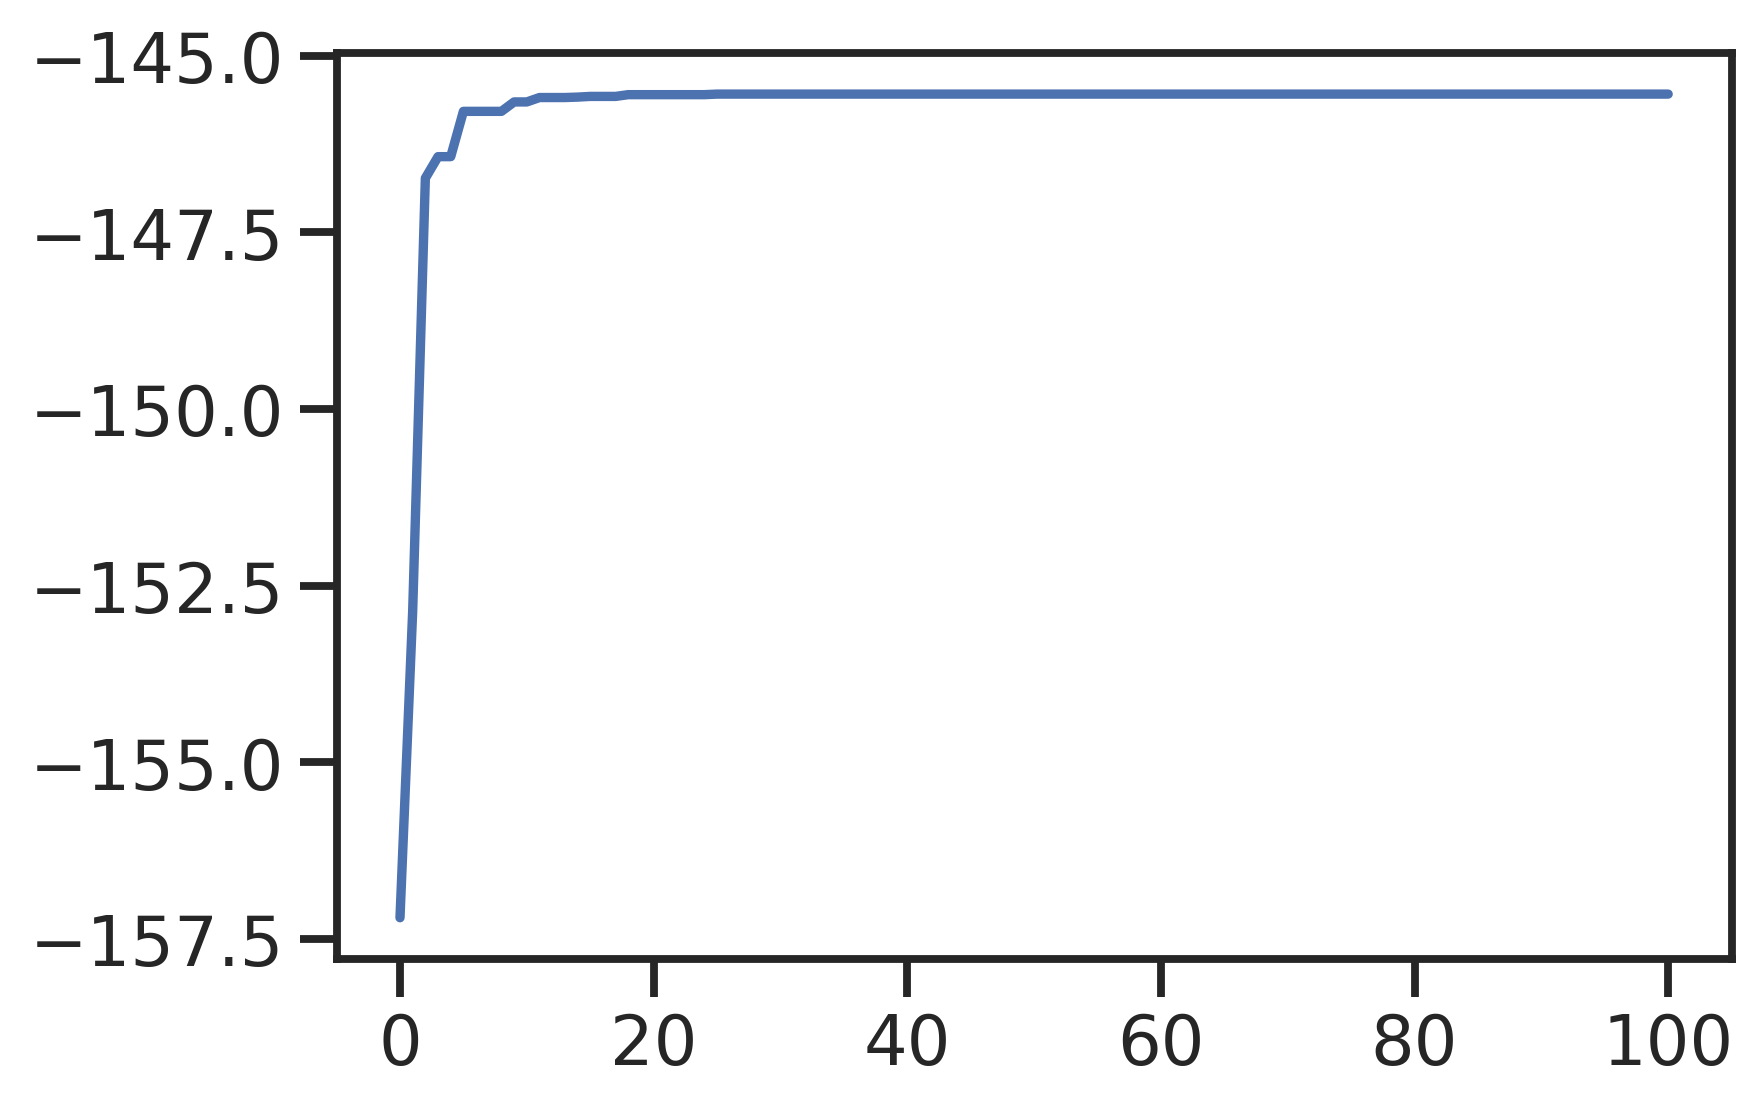

In [84]:
plt.plot(gao.best_fitness_per_generation)

In [85]:
AIC_sa = 2*len(fit_parms) + fit_cost
AIC_sa

151.54373352381978

In [86]:
fragments = surface_ablation(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

(0, 50)

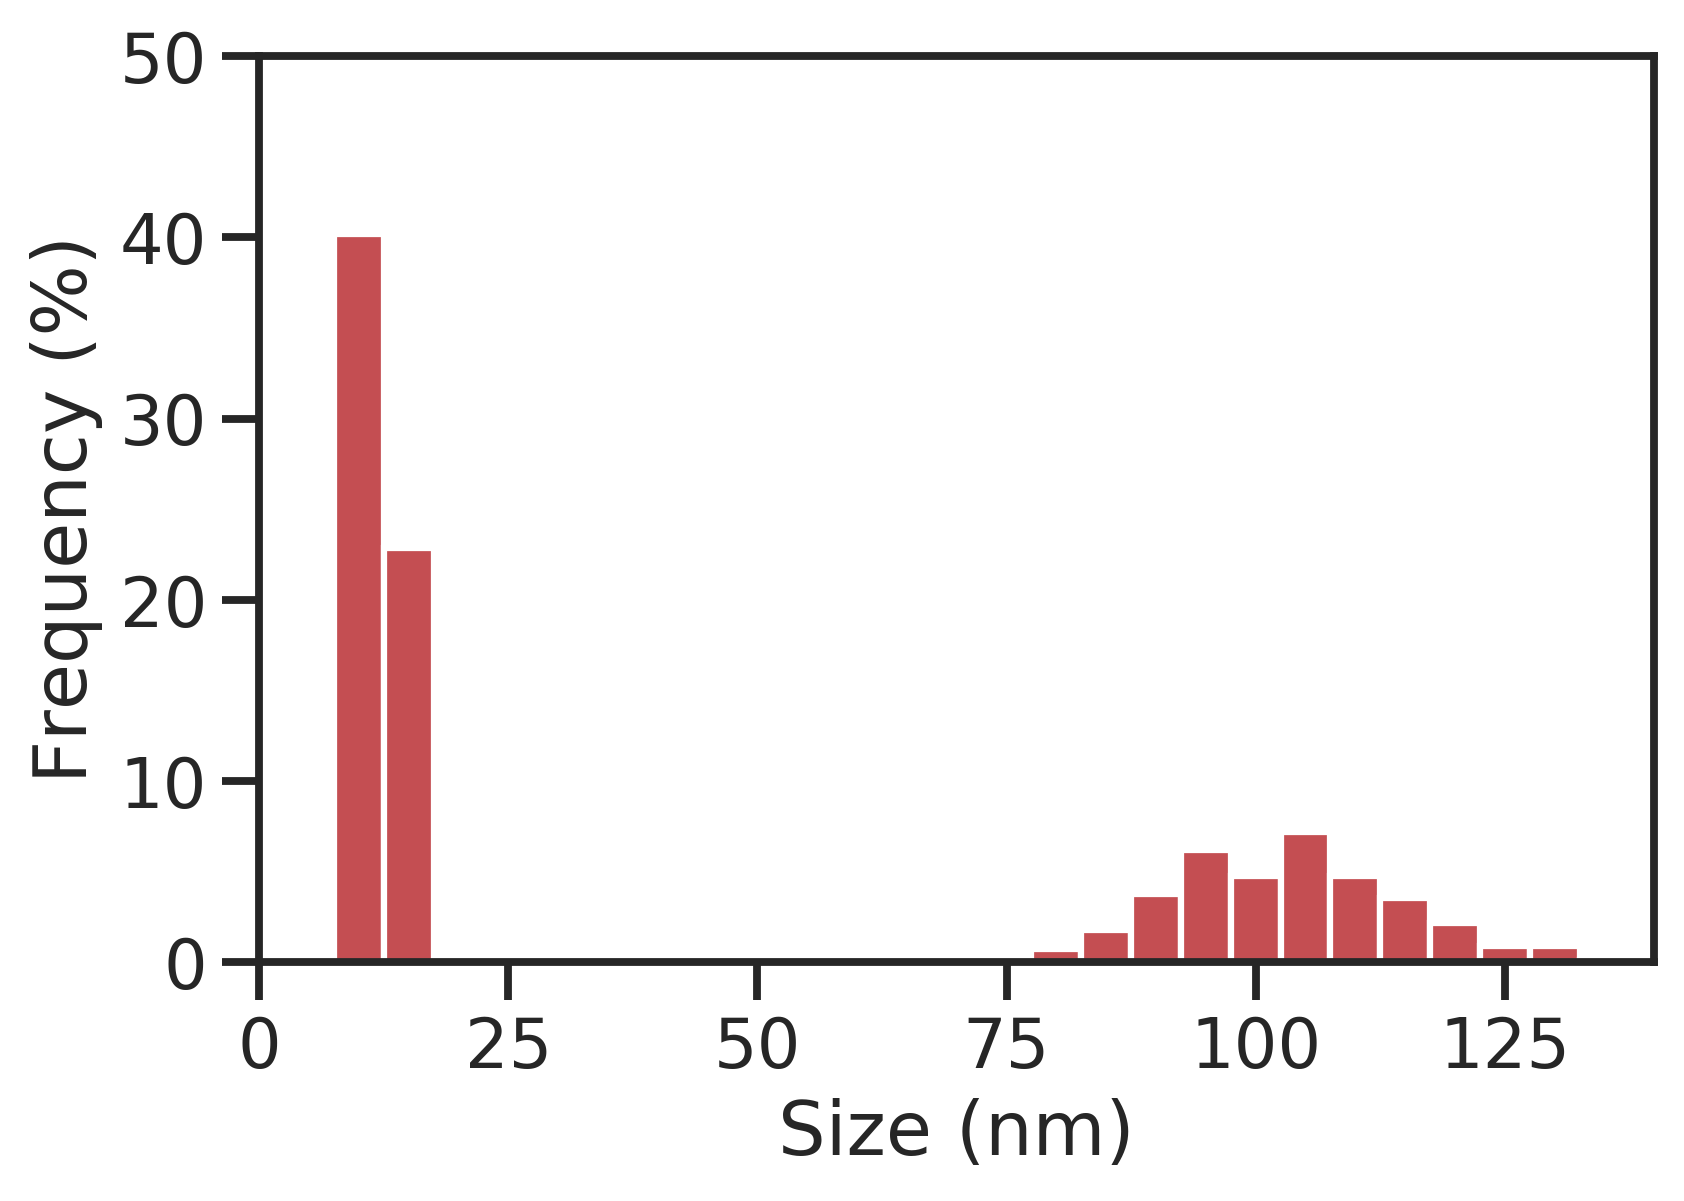

In [87]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,50))

In [88]:
fit_parms

array([1.13510670e-02, 8.64632483e-02, 1.51105098e+02])

In [89]:
np.savetxt('100nm_nlsfit_moreTEM_centers.txt', centers)
np.savetxt('100nm_nlsfit_moreTEM_edges.txt', edges)
np.savetxt('100nm_nlsfit_moreTEM_frequency_sa.txt', frag_freq)

Text(10, 44, 'SSE=146')

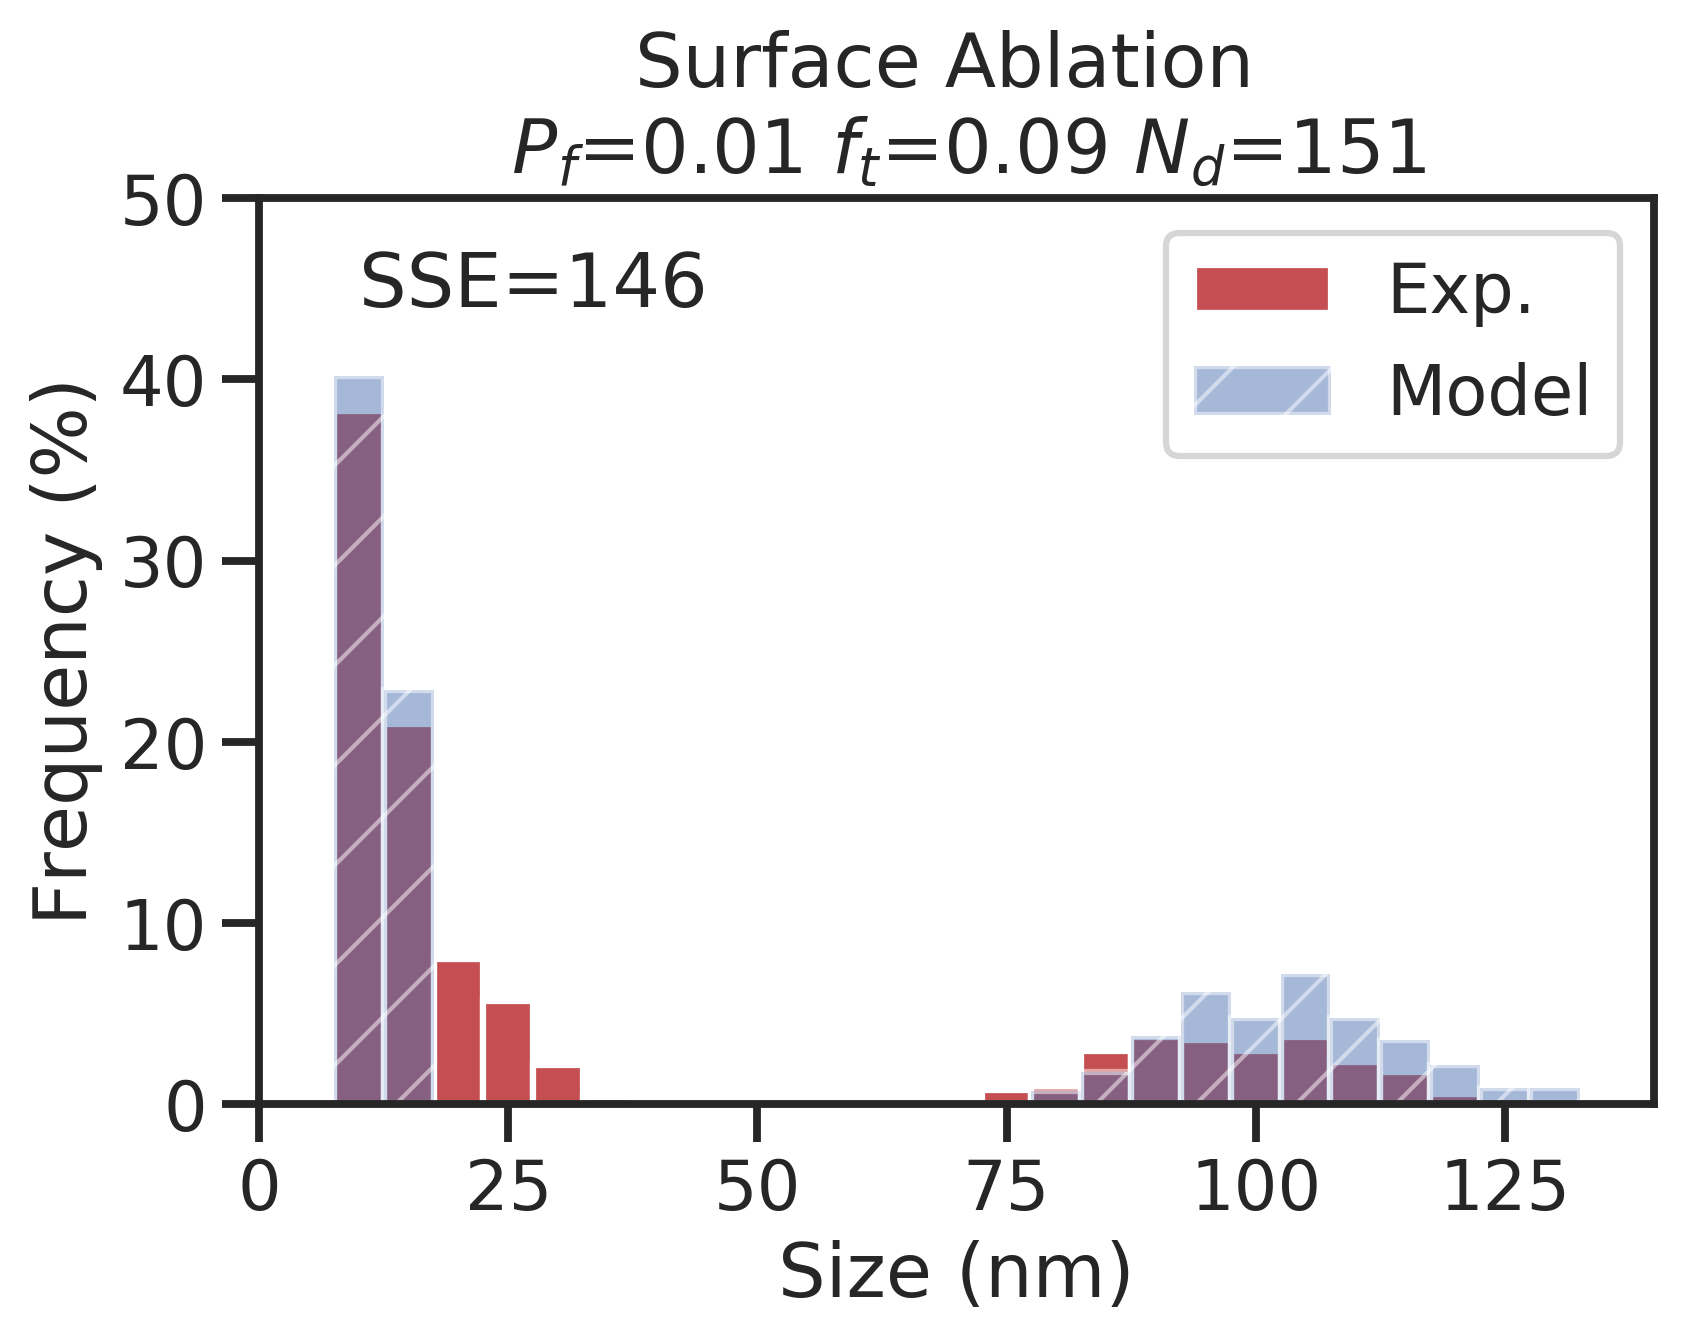

In [90]:
plt.hist(centers, bins=edges, weights=dist['laser_low'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,50))
#plt.suptitle("Surface Ablation")
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(10,44, "SSE={:.0f}".format(fit_cost))

## Particle Split - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [91]:
# Set the active point population size
population_size = 1000
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_ps, fitness_particle_split, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)

Generations: 100%|██████████| 100/100 [10:03<00:00,  6.04s/it]


[1.00593854e-02 6.17175377e+02] 482.9326323127829


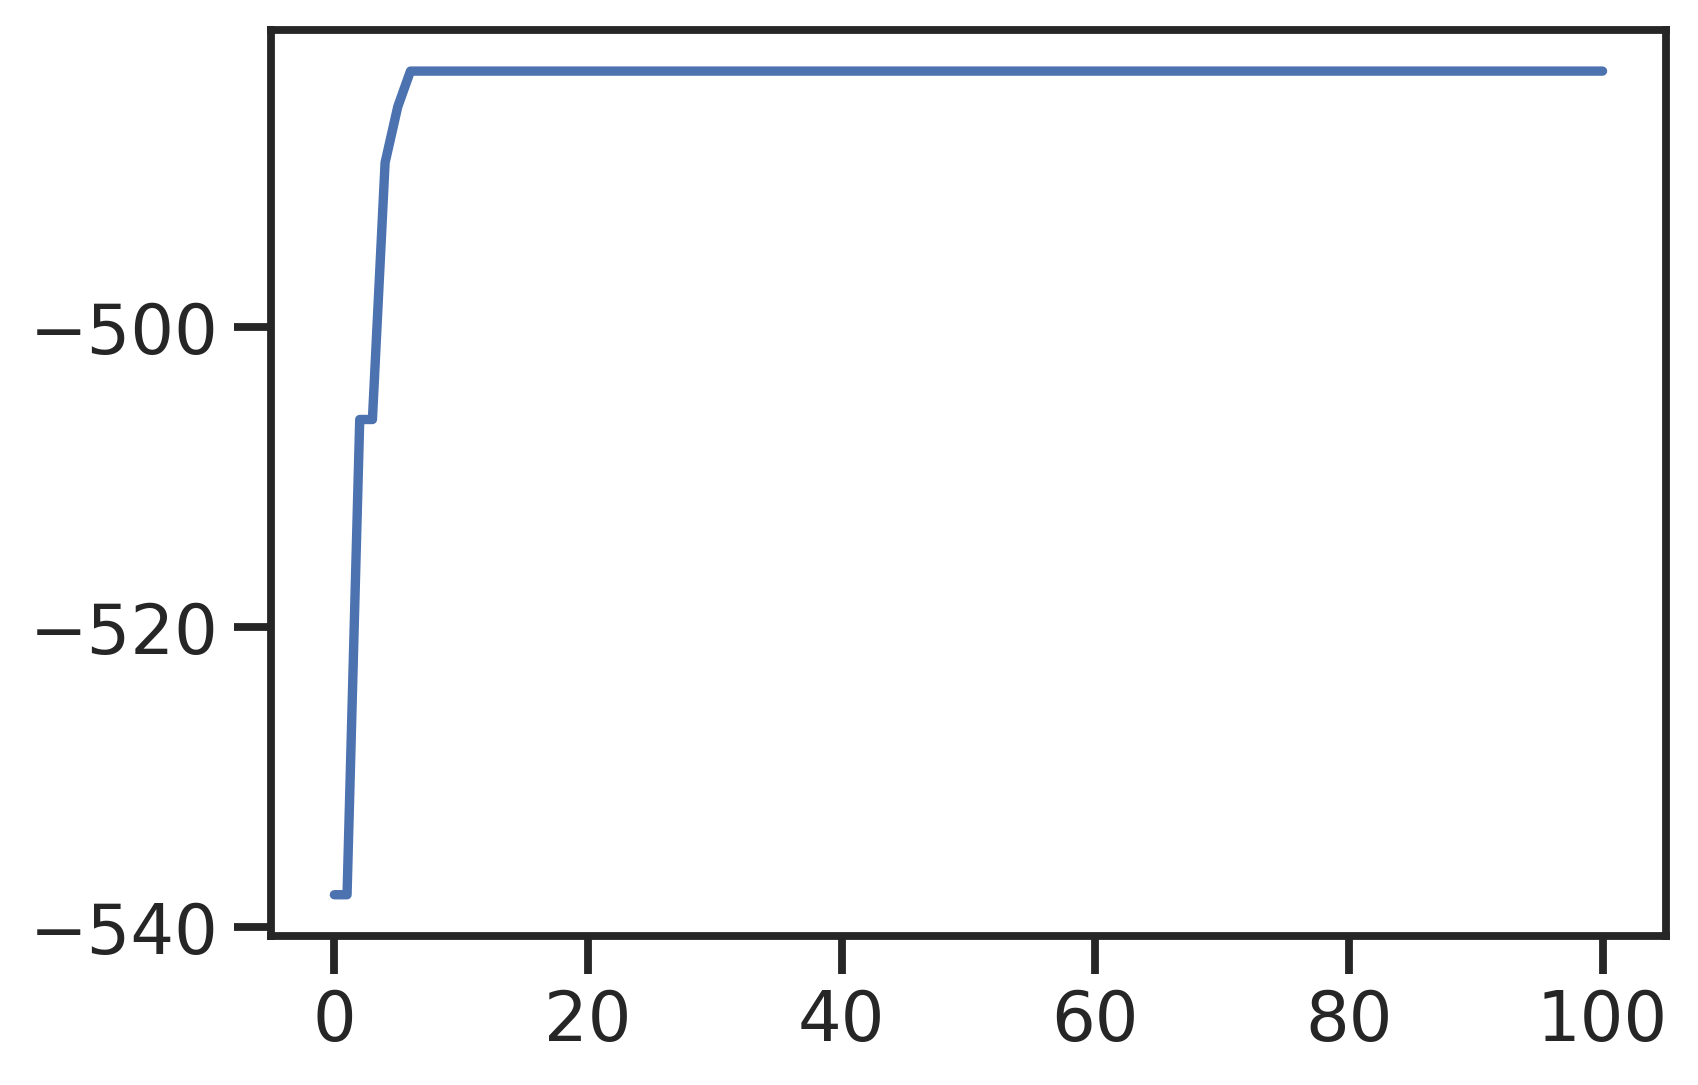

In [92]:
plt.plot(gao.best_fitness_per_generation)

In [93]:
AIC_ps = 2*len(fit_parms) + fit_cost
AIC_ps

486.9326323127829

In [94]:
fragments = particle_split(sample_sizes, fit_parms[0], int(fit_parms[1]))
frag_freq = fragment_frequency(fragments)

(0, 50)

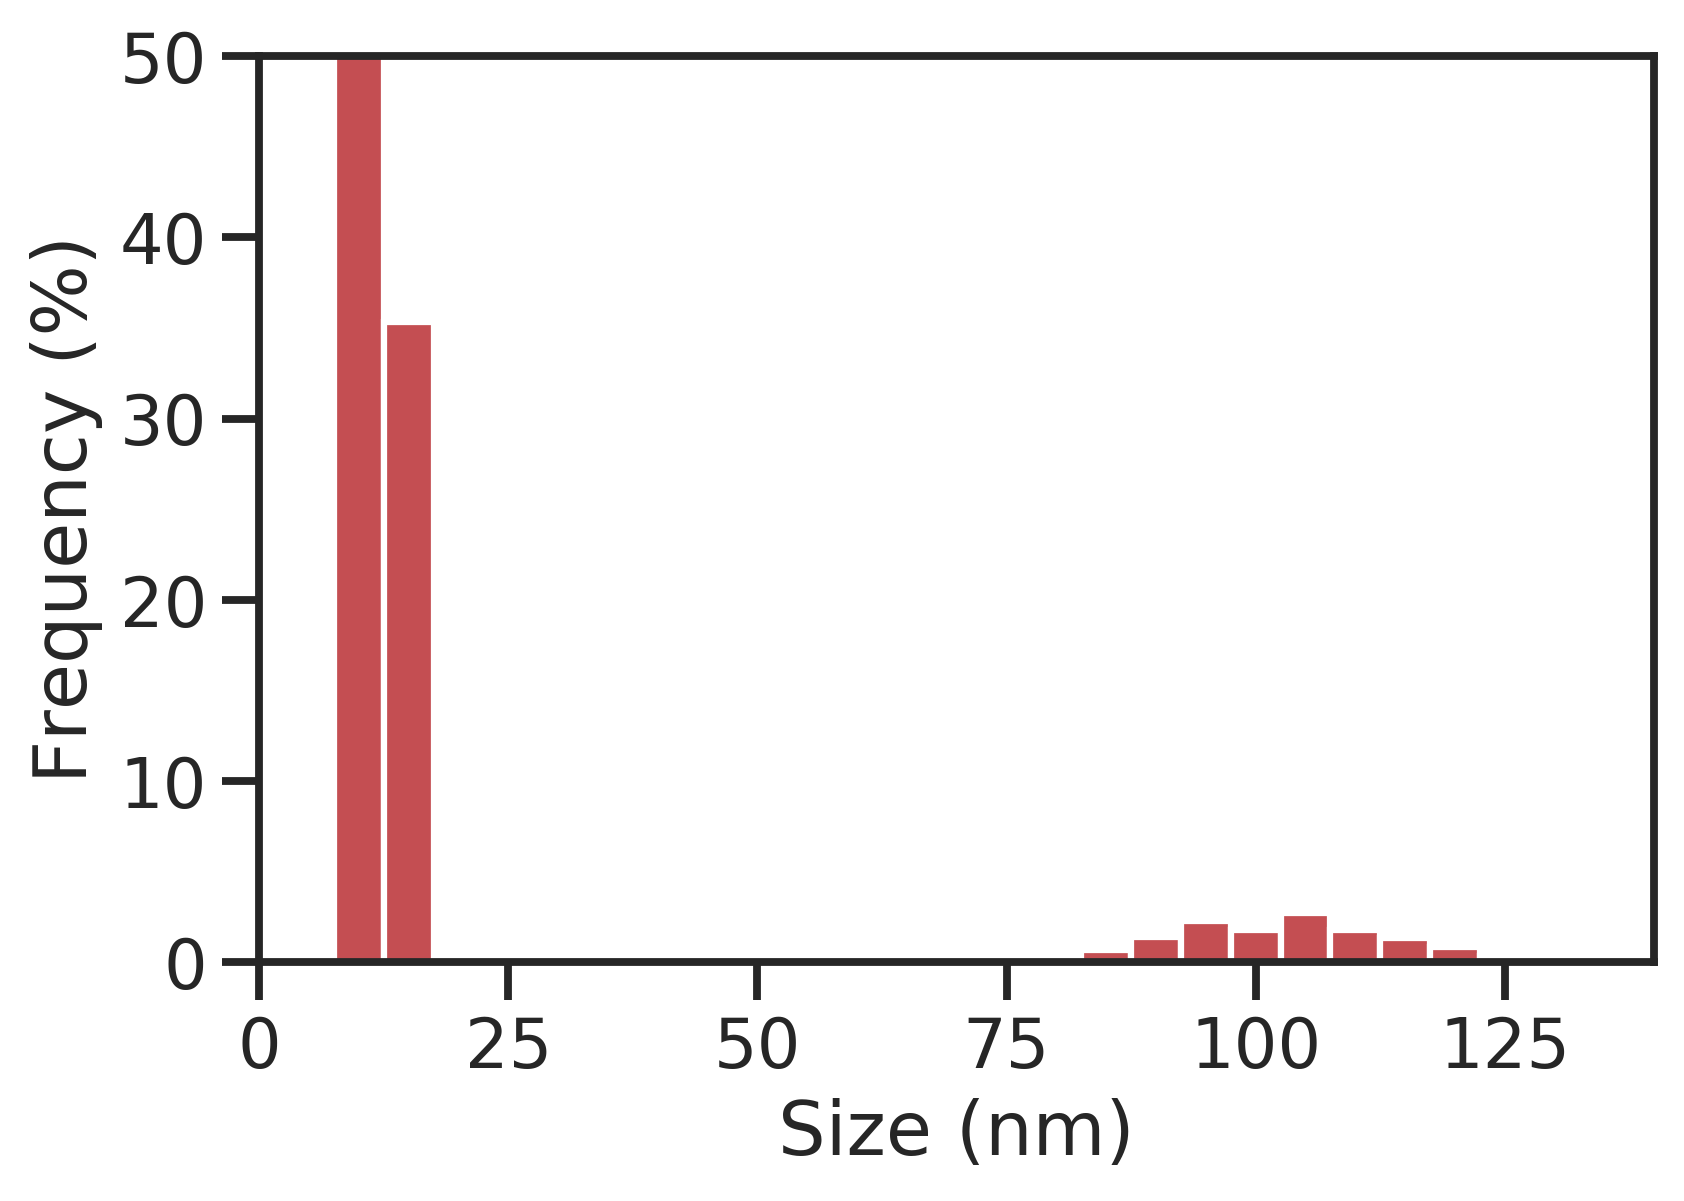

In [95]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,50))

In [96]:
np.savetxt('100nm_nlsfit_moreTEM_frequency_ps.txt', frag_freq)

Text(20, 44, 'SSE=483')

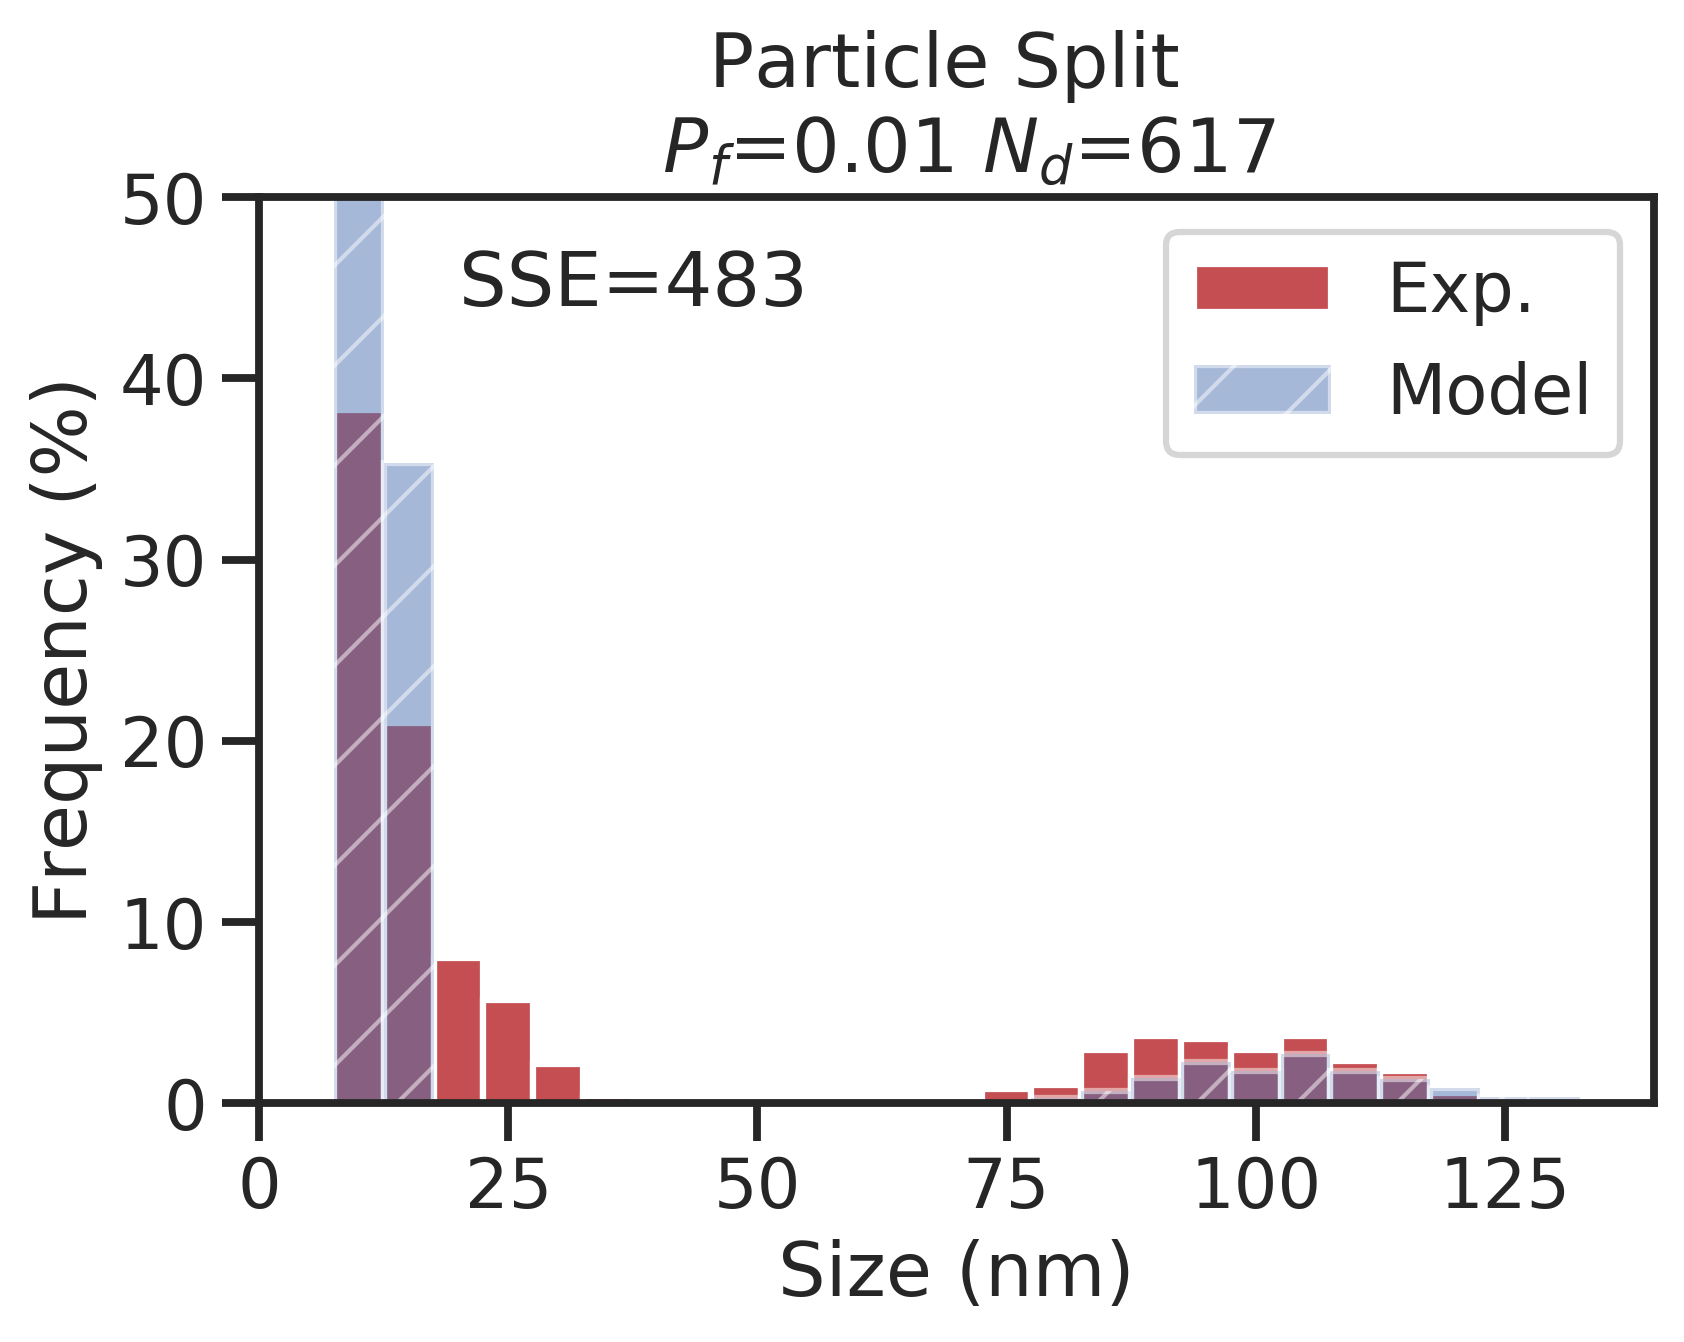

In [97]:
plt.hist(centers, bins=edges, weights=dist['laser_low'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,50))
plt.title("Particle Split \n $P_f$={:.2f} $N_d$={}".format(fit_parms[0], int(fit_parms[1])))
plt.text(20,44, "SSE={:.0f}".format(fit_cost))

## Surface Layer Ablation, Unequal - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [ ]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [ ]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

In [ ]:
import galibrate as gal

In [ ]:
gal.__path__

In [ ]:
#nrepeats = 3
# Set the active point population size
population_size = 400
#fit_parms_rep = list()
#fit_cost_rep = list()
#for rep in range(nrepeats):
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation_unequal, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run(nprocs=2)
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)
#    fit_parms_rep.append(fit_parms)
#    fit_cost_rep.append(fit_cost)
#fit_parms_rep = np.array(fit_parms_rep)
#fit_cost_rep = np.array(fit_cost_rep)
#fit_parms = fit_parms_rep.mean(axis=0)
#fit_parms_err = fit_parms_rep.std(axis=0)/np.sqrt(nrepeats)
#fit_cost = fit_cost_rep.mean()
#print(fit_parms, fit_parms_err, fit_cost)

In [ ]:
plt.plot(gao.best_fitness_per_generation)

In [ ]:
AIC_sa_ue = 2*len(fit_parms) + fit_cost
AIC_sa_ue

In [ ]:
fragments = surface_ablation_unequal(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

In [ ]:
#plt.hist(centers, bins=edges, weights=frag_freq, color='r')
#plt.xlim((0,10))
#plt.ylabel("Frequency (%)")
#plt.xlabel("Size (nm)")
#plt.ylim((0,25))

In [ ]:
plt.hist(centers, bins=edges, weights=dist['laser_low'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,50))
plt.title("Surface Ablation \n $P_f$={:.2f} $f_t$={:.2f} $N_d$={}".format(fit_parms[0], fit_parms[1], int(fit_parms[2])))
plt.text(20,44, "SSE={:.0f}".format(fit_cost))

## Particle Split, Unequal - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [ ]:
# Set the active point population size
population_size = 400
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_ps, fitness_particle_split_unequal, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run(nprocs=2)
fit_parms = 10**best_theta
fit_cost = -best_theta_fitness
print(fit_parms, fit_cost)

In [ ]:
plt.plot(gao.best_fitness_per_generation)

In [ ]:
AIC_ps = 2*len(fit_parms) + fit_cost
AIC_ps

In [ ]:
fragments = particle_split_unequal(sample_sizes, fit_parms[0], int(fit_parms[1]))
frag_freq = fragment_frequency(fragments)

In [ ]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,50))

In [ ]:
plt.hist(centers, bins=edges, weights=dist['laser_low'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,50))
plt.title("Particle Split \n $P_f$={:.2f} $N_d$={}".format(fit_parms[0], int(fit_parms[1])))
plt.text(20,44, "SSE={:.0f}".format(fit_cost))